## Summary




*   We compare the percentage of people who changed Likert responses in case vs control
  * And there is also a percentage change aggregating both groups
* We did a more comprehensive per person likert change distributions and also compared the two distributions with statistical tests
* We compare the likert change distributions and also perform statistical tests to compare the two variance
* We compare the initial likert belief distributions and also perform statistical tests to compare the two variance
* Reasons mentioned by players for change in response - we compared how many attributed their change in response to peers in both conditions. We also compared how many said they did not change their minds, and no one had an influence on them.
  * We compared the different proportions with a z-test, and also using chi-squared test.
* I then used a cosine similarity measure to compare between peer responses/ recommendations with the individuals' reasoning. (with peer responses - second stage analysis, and with recommendations - third stage analysis)
  * Second stage analysis - compared between those that changed their responses vs those that did not change their responses. (we did not find anything significant)
  * Third stage analysis - compared the histogram between followed and not followed (for both control and case)
    * Statistical test conducted - mann-whitney test
    * We also did the network belief distance as defined by Neeley.





In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import re
import os
import math

import statistics
from scipy import stats
from scipy.stats import stats
import scipy.stats as stats
from scipy.stats import ttest_ind

In [ ]:
def preprocess_data(df, columns):
    # Drop rows with NaN values in specified columns
    df = df.dropna(subset=columns)

    # Replace empty strings with pd.NA
    df[columns] = df[columns].replace('', pd.NA)

    # Convert columns to float and handle non-numeric values with NaN
    df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')

    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert columns to float dtype
    df[columns] = df[columns].astype(float)

    return df

In [ ]:
def combine_dictionaries_df(*dicts):
    # Create an empty list to store the DataFrames
    dfs = []

    # Iterate over each dictionary
    for dictionary in dicts:
        # Iterate over the values of the dictionary
        for df in dictionary.values():
            dfs.append(df)

    # Concatenate the DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    # Return the combined DataFrame
    return combined_df

###STATISTICAL TEST FUNCTIONS

In [ ]:
from scipy.stats import mannwhitneyu

def mann_whitney_u_test(data1, data2):
    """
    Perform the Mann-Whitney U test and return the test statistic and p-value.

    Parameters:
        data1: array_like
            First set of data.
        data2: array_like
            Second set of data.

    Returns:
        u_statistic: float
            The Mann-Whitney U statistic.
        p_value: float
            The two-sided p-value for the test.
    """
    u_statistic, p_value = mannwhitneyu(data1, data2)
    return u_statistic, p_value


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

def two_sample_z_test(success_a, n_a, success_b, n_b):
    """
    Perform a two-sample Z-test for proportions.

    :param success_a: The count of successes in the first sample.
    :param n_a: The number of observations in the first sample.
    :param success_b: The count of successes in the second sample.
    :param n_b: The number of observations in the second sample.
    :return: Z-statistic, P-value
    """
    count = [success_a, success_b]  # List of success counts for each sample
    nobs = [n_a, n_b]  # List of number of observations for each sample
    z_statistic, p_value = proportions_ztest(count, nobs)
    return z_statistic, p_value

In [ ]:
from scipy.stats import levene

def perform_levenes_test(sample1, sample2):
    """
    Perform Levene's test for equality of variances between two samples.

    Parameters:
    - sample1: array-like, the first sample dataset.
    - sample2: array-like, the second sample dataset.

    Returns:
    - statistic: Levene's test statistic.
    - p_value: p-value for the test statistic, indicating if variances are significantly different.
    """
    statistic, p_value = levene(sample1, sample2)

    return statistic, p_value


In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

def mann_whitney_test(df1, column1, df2, column2):
    """
    Perform a Mann-Whitney U Test on two columns from different DataFrames.

    Parameters:
    - df1: DataFrame containing the first column of data.
    - column1: The column name in df1 to test.
    - df2: DataFrame containing the second column of data.
    - column2: The column name in df2 to test.

    Returns:
    - A message with the test statistic, p-value, and the interpretation.
    """
    # Extracting data from the specified columns
    data_group1 = df1[column1]
    data_group2 = df2[column2]

    # Perform the Mann-Whitney U Test
    stat, p = mannwhitneyu(data_group1.dropna(), data_group2.dropna())  # Drop NA values to ensure valid test execution

    # Interpretation
    alpha = 0.05  # Set alpha level
    result_message = f'Statistics={stat:.3f}, p={p:.3f}. '

    if p > alpha:
        result_message += 'Same distribution (fail to reject H0)'
    else:
        result_message += 'Different distribution (reject H0)'

    return result_message



In [ ]:
from scipy import stats

def t_test(group1_data, group2_data, alpha=0.05):
    """
    Perform an independent samples t-test to compare means of two groups.
    """

    # Conduct independent samples t-test
    t_statistic, p_value = stats.ttest_ind(group1_data, group2_data)

    # Interpret the test result
    if p_value < alpha:
        interpretation = "Reject the null hypothesis. There is a significant difference between the means."
    else:
        interpretation = "Fail to reject the null hypothesis. There is no significant difference between the means."

    return t_statistic, p_value, interpretation


In [ ]:
from scipy import stats

def two_sample_t_test_unequal_var(data1, data2, alpha=0.05):
    """
    Perform a two-sample t-test assuming unequal variances to compare means of two independent groups.

    Parameters:
    - data1: Array-like, data for group 1
    - data2: Array-like, data for group 2
    - alpha: float, significance level (default is 0.05)

    Returns:
    - t_statistic: float, the calculated t-statistic
    - p_value: float, the two-tailed p-value
    - interpretation: str, interpretation of the test result
    """

    # Perform the two-sample t-test assuming unequal variances
    t_statistic, p_value = stats.ttest_ind(data1, data2, equal_var=False)

    # Interpret the test result
    if p_value < alpha:
        interpretation = "Reject the null hypothesis. There is a significant difference between the means."
    else:
        interpretation = "Fail to reject the null hypothesis. There is no significant difference between the means."

    return t_statistic, p_value, interpretation



In [ ]:
gameIDs = ['8b8dTFpeaiTPFp7Zm', 'cuTqv6xdGJfdaPmwM', 'CG7cWa4QWvsG9nxMu', 'quFcEyR6pyBDjQeRj', 'pA8QEvxkstWdRQeAh', 'DQQizT4TbeotZGD2f', 'Js68w3jJb3e72Gpyj', 'iQgq9We48TWLZPXjh', 'kYgjq882HsZb7F7jA', 'xzjPTkZ6udh5nRa6Y']

##Control

In [ ]:
# Path to CSV file CONTROL
csv_path_link_control = '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Control/'

csv_paths_folder_control = ['MturkControlData_906/', 'ProlificControlData_906/', 'Control_Quasi_23Aug/', 'Control_Quasi_7Nov/', 'Control_Quasi_8Dec/']
csv_path_control = []

for path in csv_paths_folder_control:
    csv_path_control.append(csv_path_link_control + path)

print(csv_path_control)

['/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Control/MturkControlData_906/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Control/ProlificControlData_906/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Control/Control_Quasi_23Aug/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Control/Control_Quasi_7Nov/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Control/Control_Quasi_8Dec/']


In [ ]:
df_player_rounds_control = []
df_rounds_control = []
merged_df_player_rounds_control = []

for path in csv_path_control:
  df_player_round_control = pd.read_csv(path+'player-rounds.csv')
  df_round_control = pd.read_csv(path+'rounds.csv')
  merged_df_player_round_control = pd.merge(df_player_round_control, df_round_control[['_id','index']], left_on='roundId', right_on='_id', how='left')
  df_player_rounds_control.append(df_player_round_control)
  df_rounds_control.append(df_round_control)
  merged_df_player_rounds_control.append(merged_df_player_round_control)

# print(len(merged_df_player_rounds[0]))
# print(len(merged_df_player_rounds[1]))
# print(len(merged_df_player_rounds[2]))

all_df_player_rounds_control = pd.concat(merged_df_player_rounds_control, axis=0, ignore_index=True)
print(len(all_df_player_rounds_control))

all_df_player_rounds_control = all_df_player_rounds_control[all_df_player_rounds_control['gameId'].isin(gameIDs)]

dropping_players = []  # Replace with the values you want to remove
# Remove rows with certain values in a specific column
all_df_player_rounds_control = all_df_player_rounds_control[~all_df_player_rounds_control['playerId'].isin(dropping_players)]

# all_df_player_rounds.info()

#Checking if we have 25 players.
unique_values = all_df_player_rounds_control['playerId'].nunique()
print(unique_values)


425
82


In [ ]:
all_df_player_rounds_control = all_df_player_rounds_control.rename(columns={'index': 'round_index'})

all_df_player_rounds_control['data.abs_difference_likert'] = (all_df_player_rounds_control['data.value_updated'] - all_df_player_rounds_control['data.value']).abs()
all_df_player_rounds_control['data.difference_likert'] = all_df_player_rounds_control['data.value_updated'] - all_df_player_rounds_control['data.value']


In [ ]:
df_players_control = []
df_player_inputs_control = []
merged_df_players_control = []
i = 0
for path in csv_path_control:
  df_player_ids = df_player_rounds_control[i].drop_duplicates(subset='playerId', keep='first')
  df_player = pd.read_csv(path+'players.csv')
  df_player_input = pd.read_csv(path+'player-inputs.csv')

  df_players_control.append(df_player)
  df_player_inputs_control.append(df_player_input)

  merged_df_player = pd.merge(df_player, df_player_ids[['playerId', 'gameId']], left_on='_id', right_on='playerId', how='left')
  merged_df_player = merged_df_player[merged_df_player['gameId'].isin(gameIDs)]
  merged_df_players_control.append(merged_df_player)
  i = i+1

all_df_players_control = pd.concat(merged_df_players_control, axis=0, ignore_index=True)
# Remove rows with certain values in a specific column
all_df_players_control = all_df_players_control[~all_df_players_control['playerId'].isin(dropping_players)]


len(all_df_players_control)


82

In [ ]:
#Merging players and player-rounds - Mturk_players, Mturk_merged_df_player_rounds
merged_df_players_network_control = []
i = 0
for path in csv_path_control:
  merged_df_player_network_control = pd.merge(merged_df_player_rounds_control[i], df_players_control[i], left_on='playerId', right_on='_id', how='left')
  merged_df_player_network_control = merged_df_player_network_control[merged_df_player_network_control['gameId'].isin(gameIDs)]
  merged_df_players_network_control.append(merged_df_player_network_control)
  i= i+1


all_df_players_network_control = pd.concat(merged_df_players_network_control, axis=0, ignore_index=True)

all_df_players_network_control = all_df_players_network_control.rename(columns={'index': 'round_index'})

all_df_players_network_control['data.abs_difference_likert'] = (all_df_players_network_control['data.value_updated'] - all_df_players_network_control['data.value']).abs()
all_df_players_network_control['data.difference_likert'] = all_df_players_network_control['data.value_updated'] - all_df_players_network_control['data.value']

columns_to_drop = ['bot', 'readyAt', 'timeoutStartedAt', 'timeoutWaitCount', 'exitStepsDone', 'exitAt', 'exitStatus',
                   'exitReason', 'retiredAt', 'retiredReason', 'data.avatar']
all_df_players_network_control = all_df_players_network_control.drop(columns_to_drop, axis=1)
all_df_players_network_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 39 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   _id_x                                                         410 non-null    object 
 1   batchId                                                       410 non-null    object 
 2   playerId                                                      410 non-null    object 
 3   roundId                                                       410 non-null    object 
 4   gameId                                                        410 non-null    object 
 5   createdAt_x                                                   410 non-null    object 
 6   data.value                                                    398 non-null    float64
 7   data.value_updated                                            400 non-n

##Case

In [ ]:
# Path to CSV file
csv_path_link_case = '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/'

csv_paths_folder_case = ['CaseData1407/', 'CaseData1507/', 'CaseData2607/', 'CaseData911/', 'CaseData1112/']
csv_path_case = []

for path in csv_paths_folder_case:
    csv_path_case.append(csv_path_link_case + path)

print(csv_path_case)

['/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData1407/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData1507/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData2607/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData911/', '/content/drive/MyDrive/EMPIRICA_PilotStudyData/DATA/Case_RandomAssignment/CaseData1112/']


In [ ]:
df_player_rounds_case = []
df_rounds_case = []
merged_df_player_rounds_case = []

for path in csv_path_case:
  df_player_round_case = pd.read_csv(path+'player-rounds.csv')
  df_round_case = pd.read_csv(path+'rounds.csv')
  merged_df_player_round_case = pd.merge(df_player_round_case, df_round_case[['_id','index']], left_on='roundId', right_on='_id', how='left')
  df_player_rounds_case.append(df_player_round_case)
  df_rounds_case.append(df_round_case)
  merged_df_player_rounds_case.append(merged_df_player_round_case)


all_df_player_rounds_case = pd.concat(merged_df_player_rounds_case, axis=0, ignore_index=True)
print(len(all_df_player_rounds_case))

all_df_player_rounds_case = all_df_player_rounds_case[all_df_player_rounds_case['gameId'].isin(gameIDs)]
# all_df_player_rounds.info()

dropping_players = ['oZgn7j6ZPJ6JHjziP']  # Replace with the values you want to remove
# Remove rows with certain values in a specific column
all_df_player_rounds_case = all_df_player_rounds_case[~all_df_player_rounds_case['playerId'].isin(dropping_players)]
#Checking if we have 25 players.

unique_values = all_df_player_rounds_case['playerId'].nunique()
print(unique_values)


410
81


In [ ]:
all_df_player_rounds_case = all_df_player_rounds_case.rename(columns={'index': 'round_index'})

all_df_player_rounds_case['data.abs_difference_likert'] = (all_df_player_rounds_case['data.value_updated'] - all_df_player_rounds_case['data.value']).abs()
all_df_player_rounds_case['data.difference_likert'] = all_df_player_rounds_case['data.value_updated'] - all_df_player_rounds_case['data.value']


In [ ]:
df_players_case = []
df_player_inputs_case = []
merged_df_players_case = []
i = 0
for path in csv_path_case:
  df_player_ids = df_player_rounds_case[i].drop_duplicates(subset='playerId', keep='first')
  df_player_case = pd.read_csv(path+'players.csv')
  df_player_input_case = pd.read_csv(path+'player-inputs.csv')

  df_players_case.append(df_player_case)
  df_player_inputs_case.append(df_player_input)

  merged_df_player_case = pd.merge(df_player_case, df_player_ids[['playerId', 'gameId']], left_on='_id', right_on='playerId', how='left')
  merged_df_player_case = merged_df_player_case[merged_df_player_case['gameId'].isin(gameIDs)]
  merged_df_players_case.append(merged_df_player_case)
  i = i+1

all_df_players_case = pd.concat(merged_df_players_case, axis=0, ignore_index=True)
# Remove rows with certain values in a specific column
all_df_players_case = all_df_players_case[~all_df_players_case['playerId'].isin(dropping_players)]

len(all_df_players_case)


81

In [ ]:
merged_df_players_network_case = []
i = 0

for path in csv_path_case:
    merged_df_player_network_case = pd.merge(merged_df_player_rounds_case[i], df_players_case[i], left_on='playerId', right_on='_id', how='left')
    merged_df_player_network_case = merged_df_player_network_case[merged_df_player_network_case['gameId'].isin(gameIDs)]
    merged_df_players_network_case.append(merged_df_player_network_case)
    i += 1

all_df_players_network_case = pd.concat(merged_df_players_network_case, axis=0, ignore_index=True)

all_df_players_network_case = all_df_players_network_case.rename(columns={'index': 'round_index'})

all_df_players_network_case['data.abs_difference_likert'] = (all_df_players_network_case['data.value_updated'] - all_df_players_network_case['data.value']).abs()
all_df_players_network_case['data.difference_likert'] = all_df_players_network_case['data.value_updated'] - all_df_players_network_case['data.value']

columns_to_drop = ['bot', 'readyAt', 'timeoutStartedAt', 'timeoutWaitCount', 'exitStepsDone', 'exitAt', 'exitStatus',
                   'exitReason', 'retiredAt', 'retiredReason', 'data.avatar']

# Drop specified columns
all_df_players_network_case = all_df_players_network_case.drop(columns_to_drop, axis=1)
all_df_players_network_case.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 40 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   _id_x                                           410 non-null    object 
 1   batchId                                         410 non-null    object 
 2   playerId                                        410 non-null    object 
 3   roundId                                         410 non-null    object 
 4   gameId                                          410 non-null    object 
 5   createdAt_x                                     410 non-null    object 
 6   data.value                                      407 non-null    float64
 7   data.value_updated                              409 non-null    float64
 8   data.reason                                     381 non-null    object 
 9   data.reason_updated                        

## Analysis

###Percentage change

In [ ]:
def process_and_filter_subset(subset_df, col_name):
    # Convert the specified column to numeric, coerce errors
    subset_df[col_name] = pd.to_numeric(subset_df[col_name], errors='coerce')
    subset_df.dropna(subset=[col_name], inplace=True)
    return subset_df

In [ ]:
def plot_length_frequency(subset1, subset2, labels, title):
    # Get the lengths of the subsets
    length_subset1 = len(subset1)
    length_subset2 = len(subset2)

    # Create a bar plot
    fig, ax = plt.subplots()
    bars = ax.bar(labels, [length_subset1, length_subset2])

    # Add labels, title
    ax.set_ylabel('Length')
    ax.set_title(title)

    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    # Show the plot
    plt.show()
    return length_subset1, length_subset2

In [ ]:
def plot_proportion(subset1, subset2, labels, title):
    # Get the lengths of the original dataframes
    total_subset1_length = len(subset1)
    total_subset2_length = len(subset2)

    # Calculate proportions
    proportion_subset1 = total_subset1_length / (total_subset1_length + total_subset2_length)
    proportion_subset2 = total_subset2_length / (total_subset1_length + total_subset2_length)

    # Create a bar plot
    fig, ax = plt.subplots()
    bars = ax.bar(labels, [proportion_subset1, proportion_subset2])

    # Add labels, title
    ax.set_ylabel('Proportion')
    ax.set_title(title)

    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.ylim(0, 1)
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 2):.2%}', ha='center', va='bottom')

    # Show the plot
    plt.show()
    return proportion_subset1, proportion_subset2


In [ ]:
import matplotlib.pyplot as plt

def plot_percentage(subset1, subset2, labels, title, y_label, x_lim=None, y_lim=None):
    # Get the lengths of the original dataframes
    total_subset1_length = len(subset1)
    total_subset2_length = len(subset2)

    # Calculate percentages
    percentage_subset1 = (total_subset1_length / (total_subset1_length + total_subset2_length)) * 100
    percentage_subset2 = (total_subset2_length / (total_subset1_length + total_subset2_length)) * 100

    # Create a bar plot
    fig, ax = plt.subplots()
    bars = ax.bar(labels, [percentage_subset1, percentage_subset2])

    # Add labels and title
    #ax.set_xlabel(x_label)  # Set the x-label
    ax.set_ylabel(y_label)  # Set the y-label to reflect percentages
    ax.set_title(title)

    # Set x and y axis limits if specified
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        # Setting y_lim to accommodate percentage values
        ax.set_ylim(y_lim)

    # Add percentage values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 2):.2f}%', ha='center', va='bottom')

    # Show the plot
    plt.show()
    return percentage_subset1, percentage_subset2


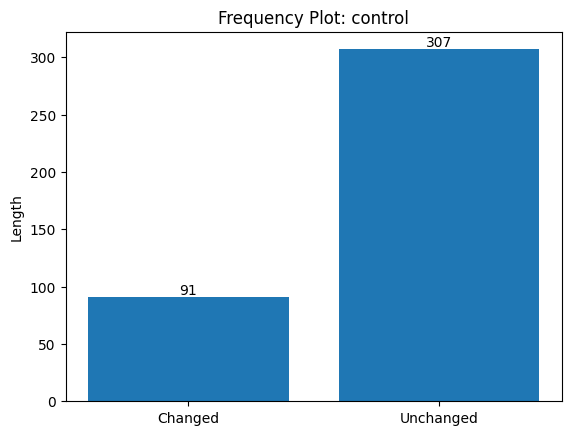

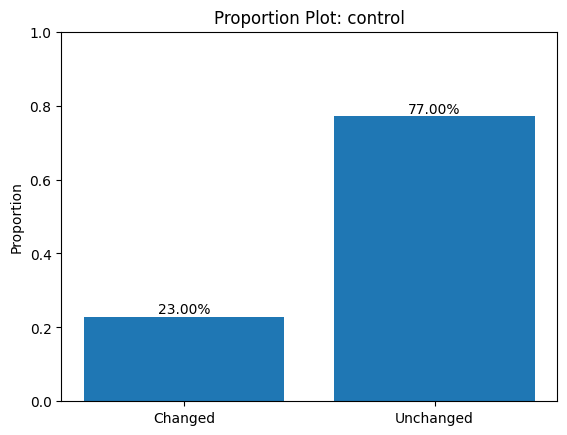

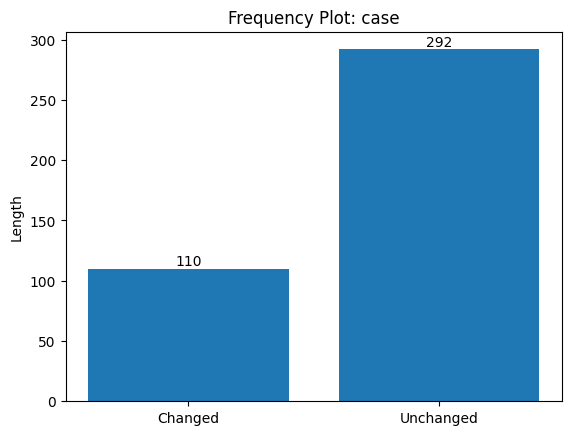

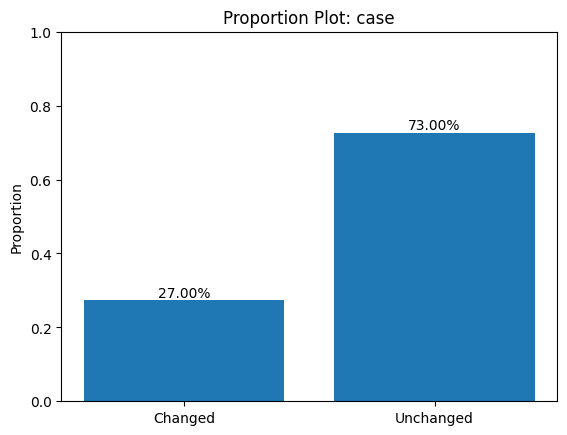

Z-statistic: -1.4668673206519387
p-value: 0.14241215187850884


In [ ]:
#preprocessing
all_df_player_rounds_control_for_belief_change = all_df_player_rounds_control
all_df_player_rounds_control_for_belief_change = process_and_filter_subset(all_df_player_rounds_control_for_belief_change, 'data.difference_likert')

all_df_player_rounds_case_for_belief_change = all_df_player_rounds_case
all_df_player_rounds_case_for_belief_change = process_and_filter_subset(all_df_player_rounds_case_for_belief_change, 'data.difference_likert')


#calculation
subset_combined_df_changed_answer_control = all_df_player_rounds_control_for_belief_change[all_df_player_rounds_control_for_belief_change['data.difference_likert'] != 0]
subset_combined_df_unchanged_answer_control  = all_df_player_rounds_control_for_belief_change[all_df_player_rounds_control_for_belief_change['data.difference_likert'] == 0]

changed_freq_control, unchanged_freq_control = plot_length_frequency(subset_combined_df_changed_answer_control, subset_combined_df_unchanged_answer_control, labels=('Changed', 'Unchanged'), title='Frequency Plot: control')
changed_per_control, unchanged_per_control = plot_proportion(subset_combined_df_changed_answer_control, subset_combined_df_unchanged_answer_control, labels=('Changed', 'Unchanged'), title='Proportion Plot: control')

subset_combined_df_changed_answer_case = all_df_player_rounds_case_for_belief_change[all_df_player_rounds_case_for_belief_change['data.difference_likert'] != 0]
subset_combined_df_unchanged_answer_case   = all_df_player_rounds_case_for_belief_change[all_df_player_rounds_case_for_belief_change['data.difference_likert'] == 0]

changed_freq_case, unchanged_freq_case = plot_length_frequency(subset_combined_df_changed_answer_case , subset_combined_df_unchanged_answer_case, labels=('Changed', 'Unchanged'), title='Frequency Plot: case')
changed_per_case, unchanged_per_case = plot_proportion(subset_combined_df_changed_answer_case, subset_combined_df_unchanged_answer_case, labels=('Changed', 'Unchanged'), title='Proportion Plot: case')

z_statistic, p_value = two_sample_z_test(changed_freq_control, len(all_df_player_rounds_control_for_belief_change), changed_freq_case, len(all_df_player_rounds_case_for_belief_change))
print("Z-statistic:", z_statistic)
print("p-value:", p_value)



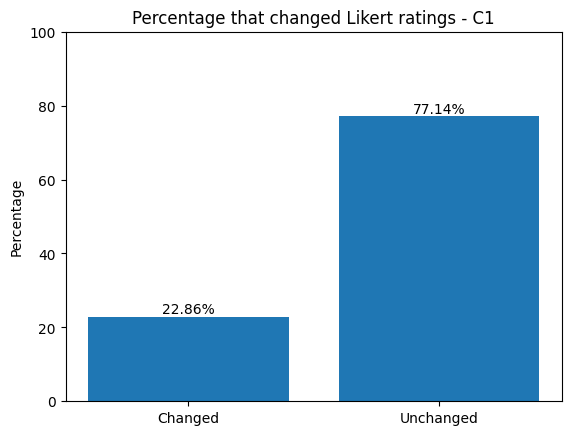

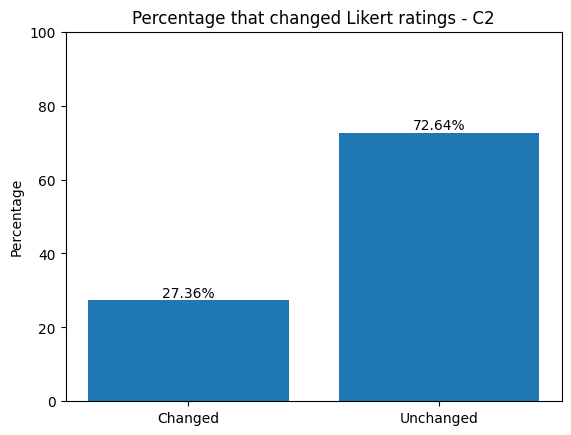

In [ ]:
changed_per_control, unchanged_per_control = plot_percentage(subset_combined_df_changed_answer_control, subset_combined_df_unchanged_answer_control, labels=('Changed', 'Unchanged'), title='Percentage that changed Likert ratings - C1', y_label= "Percentage", x_lim=None, y_lim=(0,100))
changed_per_case, unchanged_per_case = plot_percentage(subset_combined_df_changed_answer_case, subset_combined_df_unchanged_answer_case, labels=('Changed', 'Unchanged'), title='Percentage that changed Likert ratings - C2', y_label= "Percentage", x_lim=None, y_lim=(0,100))

#plot_percentage(subset1, subset2, labels, title, x_label, y_label, x_lim=None, y_lim=None)

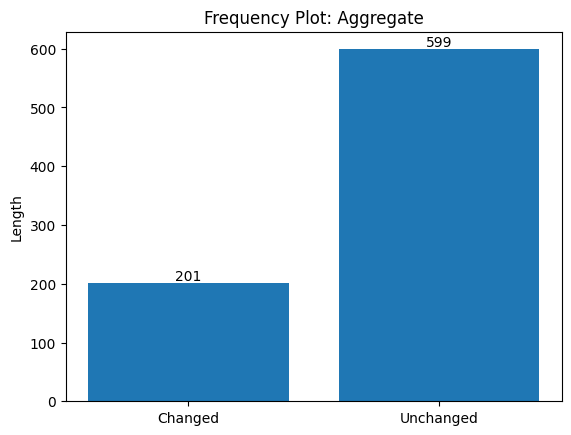

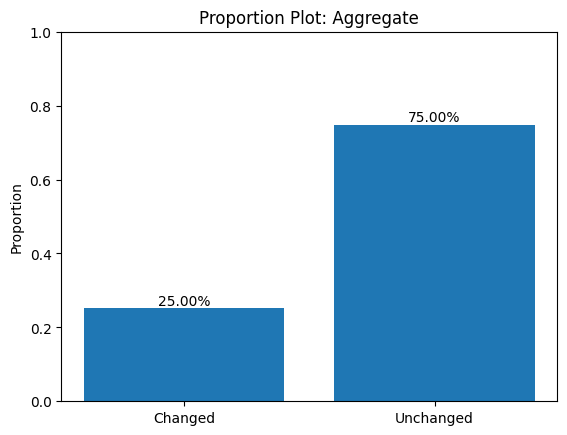

In [ ]:
all_df_player_rounds_ALL = pd.concat([all_df_player_rounds_control_for_belief_change, all_df_player_rounds_case_for_belief_change], ignore_index=True)
all_df_player_rounds_ALL = process_and_filter_subset(all_df_player_rounds_ALL, 'data.difference_likert')

subset_combined_df_changed_answer_ALL = all_df_player_rounds_ALL[all_df_player_rounds_ALL['data.difference_likert'] != 0]
subset_combined_df_unchanged_answer_ALL  = all_df_player_rounds_ALL[all_df_player_rounds_ALL['data.difference_likert'] == 0]

changed_freq_ALL, unchanged_freq_ALL = plot_length_frequency(subset_combined_df_changed_answer_ALL, subset_combined_df_unchanged_answer_ALL, labels=('Changed', 'Unchanged'), title='Frequency Plot: Aggregate')
changed_per_ALL, unchanged_per_ALL = plot_proportion(subset_combined_df_changed_answer_ALL, subset_combined_df_unchanged_answer_ALL, labels=('Changed', 'Unchanged'), title='Proportion Plot: Aggregate')


###Belief distribution per person

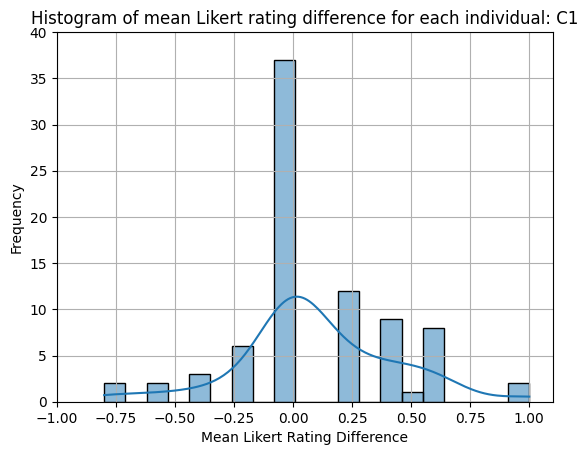

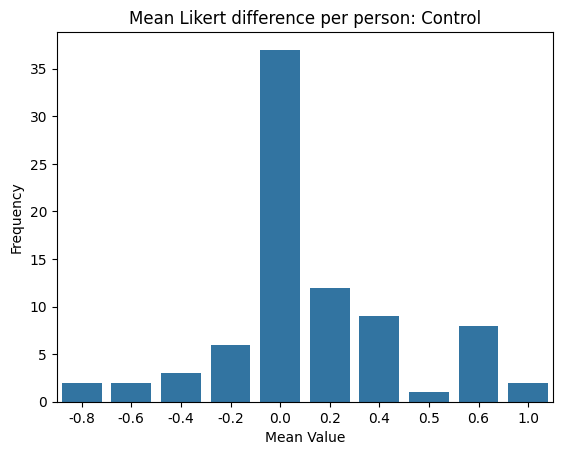

Variance of Mean Likert Difference Control: 0.11073923517012949


In [ ]:
#for initial likert values

playerIDs = all_df_player_rounds_control['playerId'].unique()

filtered_df_control = all_df_player_rounds_control[all_df_player_rounds_control['playerId'].isin(playerIDs)]

# Calculate the mean of the "Value" column for each ID
mean_values_initial_likert_control = filtered_df_control.groupby('playerId')['data.difference_likert'].mean().round(3).reset_index()

# Count the occurrences of each mean value
mean_value_counts = mean_values_initial_likert_control['data.difference_likert'].value_counts().reset_index()
mean_value_counts.columns = ['Mean Value', 'Frequency']


sns.histplot(mean_values_initial_likert_control, bins=20, kde=True, legend=False)  # Adjust 'bins' as needed, 'kde=True' adds a density curve
plt.xlabel('Mean Likert Rating Difference')
plt.ylabel('Frequency')
plt.title('Histogram of mean Likert rating difference for each individual: C1')
plt.grid(True)  # Optional: Adds a grid for easier readability
# Display the histogram
plt.xlim(-1, 1.1)
plt.ylim(0, 40)
plt.show()

# Sort the DataFrame by the "Mean Value" column for plotting
mean_value_counts = mean_value_counts.sort_values(by='Mean Value')
#print(mean_value_counts)

# Create a bar chart
sns.barplot(x='Mean Value', y='Frequency', data=mean_value_counts)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Mean Likert difference per person: Control')
# Display the chart
plt.show()

# Calculate the variance of the mean Likert differences
variance_of_mean_likert_differences_control = mean_values_initial_likert_control['data.difference_likert'].var()
print(f"Variance of Mean Likert Difference Control: {variance_of_mean_likert_differences_control}")


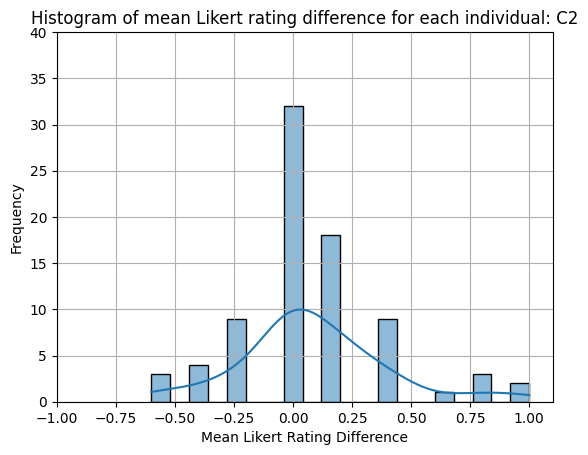

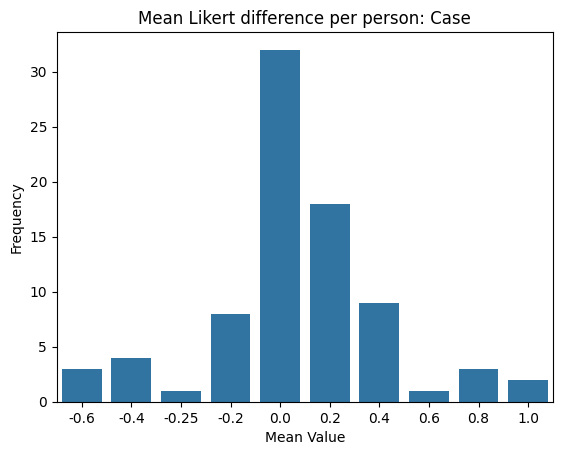

Variance of Mean Likert Difference Case: 0.09932716049382716


In [ ]:
#for initial likert values

playerIDs = all_df_player_rounds_case['playerId'].unique()

filtered_df_case = all_df_player_rounds_case[all_df_player_rounds_case['playerId'].isin(playerIDs)]

# Calculate the mean of the "Value" column for each ID
mean_values_initial_likert_case = filtered_df_case.groupby('playerId')['data.difference_likert'].mean().round(3).reset_index()

# Count the occurrences of each mean value
mean_value_counts = mean_values_initial_likert_case['data.difference_likert'].value_counts().reset_index()
mean_value_counts.columns = ['Mean Value', 'Frequency']

sns.histplot(mean_values_initial_likert_case, bins=20, kde=True, legend=False)  # Adjust 'bins' as needed, 'kde=True' adds a density curve
plt.xlabel('Mean Likert Rating Difference')
plt.ylabel('Frequency')
plt.title('Histogram of mean Likert rating difference for each individual: C2')
plt.grid(True)  # Optional: Adds a grid for easier readability
# Display the histogram
plt.xlim(-1, 1.1)
plt.ylim(0, 40)
plt.show()


# Sort the DataFrame by the "Mean Value" column for plotting
mean_value_counts = mean_value_counts.sort_values(by='Mean Value')
#print(mean_value_counts)

# Create a bar chart
sns.barplot(x='Mean Value', y='Frequency', data=mean_value_counts)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Mean Likert difference per person: Case')
# Display the chart
plt.show()

# Calculate the variance of the mean Likert differences
variance_of_mean_likert_differences_case = mean_values_initial_likert_case['data.difference_likert'].var()
print(f"Variance of Mean Likert Difference Case: {variance_of_mean_likert_differences_case}")


In [ ]:
#levene test across variance

levene_statistic, p_value = perform_levenes_test(mean_values_initial_likert_control['data.difference_likert'], mean_values_initial_likert_case['data.difference_likert'])
print(f"Levene's test statistic: {levene_statistic}, p-value: {p_value}")

Levene's test statistic: 0.06547255867157505, p-value: 0.7983731669624334


###Likert difference distribution

In [ ]:
def plot_bar(x_, y_, xlabel, ylabel, title, type):
  plt.bar(y_, x_)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  if type=='relative':
    plt.ylim(0,1)
  plt.show()


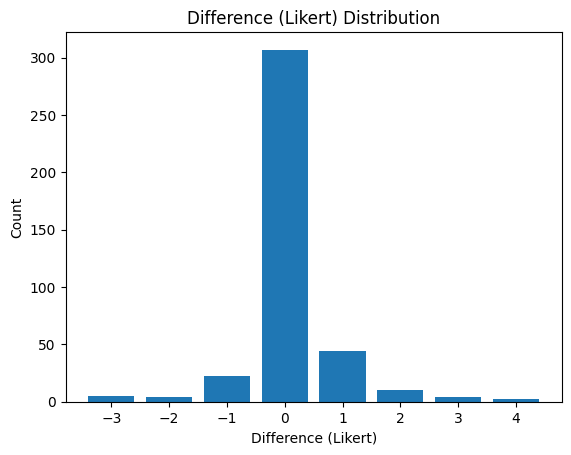

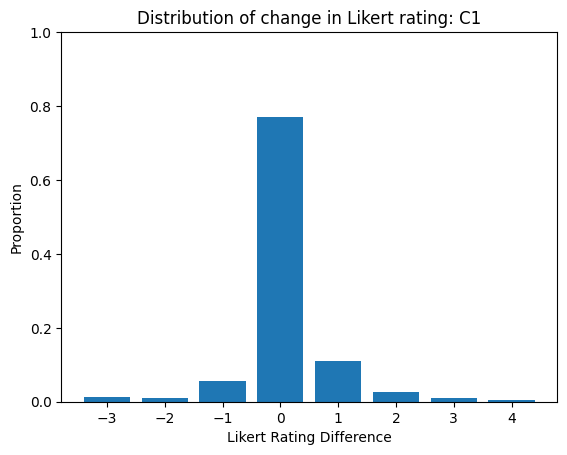

Variance of Likert Differences: 0.582313329873549
Shapiro-Wilk Test: statistic=0.6307084560394287, p-value=2.2846148964886716e-28
D'Agostino's K-squared Test: statistic=91.93776420547161, p-value=1.0863459847991492e-20


In [ ]:
# Count the frequency of each absolute difference in Likert response CONTROL
difference_likert_counts = all_df_player_rounds_control['data.difference_likert'].value_counts()
plot_bar(difference_likert_counts.values, difference_likert_counts.index.astype(int), 'Difference (Likert)', 'Count', 'Difference (Likert) Distribution', 'absolute')

num_diff_likert_control = all_df_player_rounds_control['data.difference_likert'].value_counts().sort_index()
num_diff_likert_control.index = num_diff_likert_control.index.astype(int)
num_diff_likert_dict = num_diff_likert_control.to_dict()

# Calculate relative frequencies (proportions)
total_diff_likert_responses = len(all_df_player_rounds_control['data.difference_likert'])
relative_frequency_diff_likert = difference_likert_counts / total_diff_likert_responses

# Plot a bar plot of the Likert difference distribution based on proportions
plot_bar(relative_frequency_diff_likert.values, relative_frequency_diff_likert.index.astype(int), 'Likert Rating Difference', 'Proportion', 'Distribution of change in Likert rating: C1', 'relative')

variance_likert_differences = all_df_player_rounds_control['data.difference_likert'].var()
print(f"Variance of Likert Differences: {variance_likert_differences}")

# Statistical test: Shapiro-Wilk Test
shapiro_test = stats.shapiro(all_df_player_rounds_control['data.difference_likert'])
print(f"Shapiro-Wilk Test: statistic={shapiro_test[0]}, p-value={shapiro_test[1]}")

# Statistical test: D'Agostino's K-squared Test
dagostino_test = stats.normaltest(all_df_player_rounds_control['data.difference_likert'])
print(f"D'Agostino's K-squared Test: statistic={dagostino_test[0]}, p-value={dagostino_test[1]}")

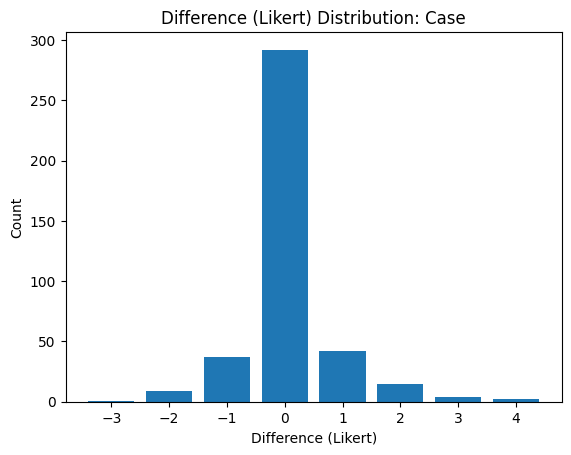

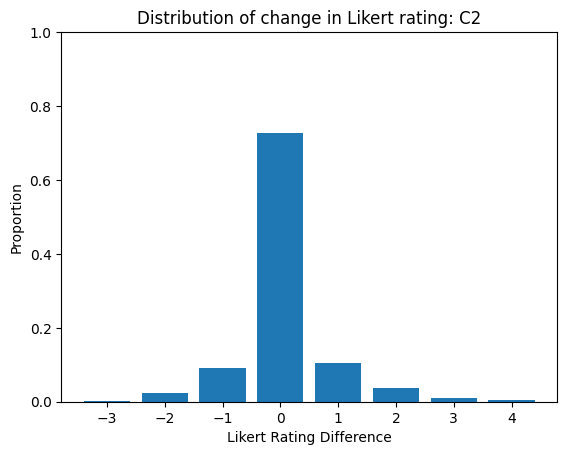

Variance of Likert Differences: 0.6212578007717026
Shapiro-Wilk Test: statistic=0.7063646912574768, p-value=6.276465172909259e-26
D'Agostino's K-squared Test: statistic=106.23285284467781, p-value=8.547303127587584e-24


In [ ]:
# Count the frequency of each absolute difference in Likert response for the case group
difference_likert_counts = all_df_player_rounds_case['data.difference_likert'].value_counts()
plot_bar(difference_likert_counts.values, difference_likert_counts.index.astype(int), 'Difference (Likert)', 'Count', 'Difference (Likert) Distribution: Case', 'absolute')

num_diff_likert_case = all_df_player_rounds_case['data.difference_likert'].value_counts().sort_index()
num_diff_likert_case.index = num_diff_likert_case.index.astype(int)
num_diff_likert_dict = num_diff_likert_case.to_dict()

# Calculate relative frequencies (proportions) for the case group
total_diff_likert_responses = len(all_df_player_rounds_case['data.difference_likert'])
relative_frequency_diff_likert = difference_likert_counts / total_diff_likert_responses

# Plot a bar plot of the Likert difference distribution based on proportions for the case group
plot_bar(relative_frequency_diff_likert.values, relative_frequency_diff_likert.index.astype(int), 'Likert Rating Difference', 'Proportion', 'Distribution of change in Likert rating: C2', 'relative')

variance_likert_differences = all_df_player_rounds_case['data.difference_likert'].var()
print(f"Variance of Likert Differences: {variance_likert_differences}")

# Statistical test: Shapiro-Wilk Test
shapiro_test = stats.shapiro(all_df_player_rounds_case['data.difference_likert'])
print(f"Shapiro-Wilk Test: statistic={shapiro_test[0]}, p-value={shapiro_test[1]}")

# Statistical test: D'Agostino's K-squared Test
dagostino_test = stats.normaltest(all_df_player_rounds_case['data.difference_likert'])
print(f"D'Agostino's K-squared Test: statistic={dagostino_test[0]}, p-value={dagostino_test[1]}")


In [ ]:
levene_statistic, p_value = perform_levenes_test(num_diff_likert_control, num_diff_likert_case)
print(f"Levene's test statistic: {levene_statistic}, p-value: {p_value}")

Levene's test statistic: 2.545500827287769e-05, p-value: 0.9960456418166893


###Initial belief distribution

mean_initial_likert_counts_control 3.886934673366834


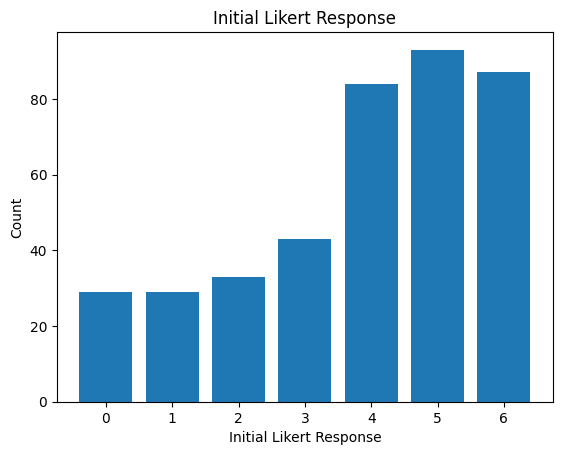

Skewness_control -0.6959259052866046
0    29
1    29
2    33
3    43
4    84
5    93
6    87
Name: data.value, dtype: int64


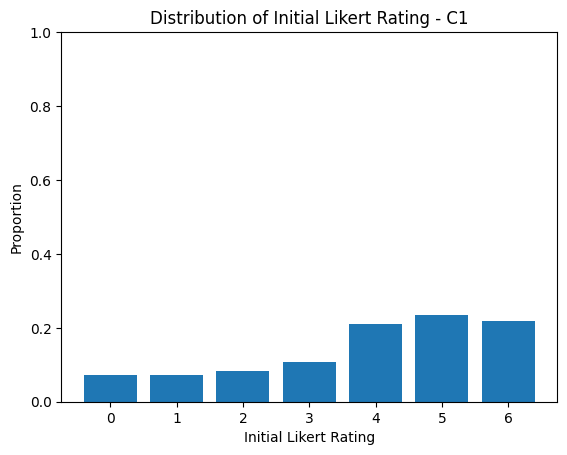

In [ ]:
# Control

initial_likert_counts = all_df_player_rounds_control['data.value'].value_counts()
mean_initial_likert_counts_control = np.mean(all_df_player_rounds_control['data.value'])
print("mean_initial_likert_counts_control", mean_initial_likert_counts_control)

plot_bar(initial_likert_counts.values, initial_likert_counts.index, 'Initial Likert Response', 'Count', 'Initial Likert Response', 'Absolute')

skewness = stats.skew(all_df_player_rounds_control['data.value'])
print("Skewness_control", skewness)

num_initial_Likert = all_df_player_rounds_control['data.value'].value_counts().sort_index()
num_initial_Likert.index = num_initial_Likert.index.astype(int)
print(num_initial_Likert)
num_initial_Likert_dict = num_initial_Likert.to_dict()


total_responses = len(all_df_player_rounds_control['data.value'])
relative_frequency_likert = initial_likert_counts / total_responses

# Plot a bar plot of the initial Likert response distribution based on proportions
plot_bar(relative_frequency_likert.values, relative_frequency_likert.index, 'Initial Likert Rating', 'Proportion', 'Distribution of Initial Likert Rating - C1', 'relative')

# Convert Likert response counts to a dictionary
likert_counts_dict = relative_frequency_likert.to_dict()
likert_counts_dict = dict(sorted(likert_counts_dict.items()))


mean_initial_likert_counts_case 3.925373134328358
Skewness_case -0.6685126077930162


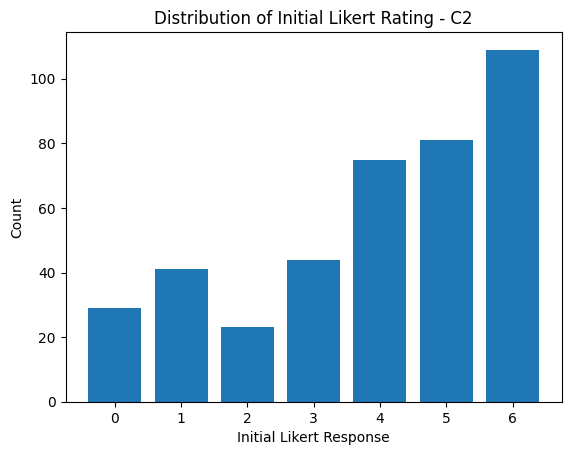

0     29
1     41
2     23
3     44
4     75
5     81
6    109
Name: data.value, dtype: int64


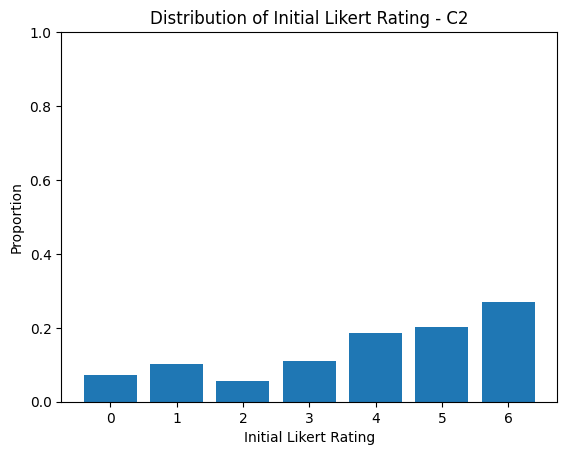

In [ ]:
# Case

initial_likert_counts = all_df_player_rounds_case['data.value'].value_counts()
mean_initial_likert_counts_case = np.mean(all_df_player_rounds_case['data.value'])
print("mean_initial_likert_counts_case", mean_initial_likert_counts_case)

skewness = stats.skew(all_df_player_rounds_case['data.value'])
print("Skewness_case", skewness)


plot_bar(initial_likert_counts.values, initial_likert_counts.index, 'Initial Likert Response', 'Count', 'Distribution of Initial Likert Rating - C2', 'Absolute')


num_initial_Likert = all_df_player_rounds_case['data.value'].value_counts().sort_index()
num_initial_Likert.index = num_initial_Likert.index.astype(int)
print(num_initial_Likert)
num_initial_Likert_dict = num_initial_Likert.to_dict()


total_responses = len(all_df_player_rounds_case['data.value'])
relative_frequency_likert = initial_likert_counts / total_responses

# Plot a bar plot of the initial Likert response distribution based on proportions
plot_bar(relative_frequency_likert.values, relative_frequency_likert.index, 'Initial Likert Rating', 'Proportion', 'Distribution of Initial Likert Rating - C2', 'relative')

# Convert Likert response counts to a dictionary
likert_counts_dict = relative_frequency_likert.to_dict()
likert_counts_dict = dict(sorted(likert_counts_dict.items()))


mean_initial_likert_counts_ALL 3.90625
Skewness_ALL -0.6801876766887209


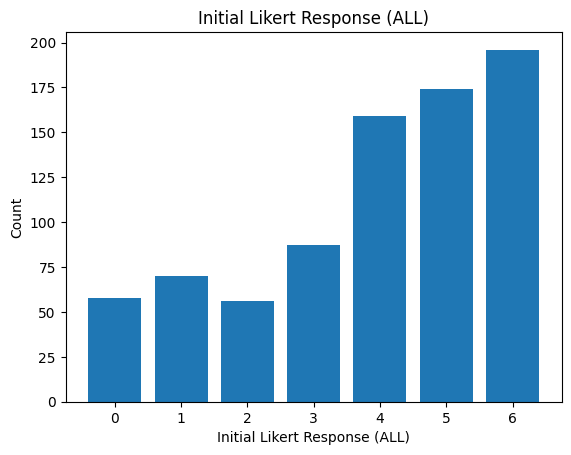

0     58
1     70
2     56
3     87
4    159
5    174
6    196
Name: data.value, dtype: int64


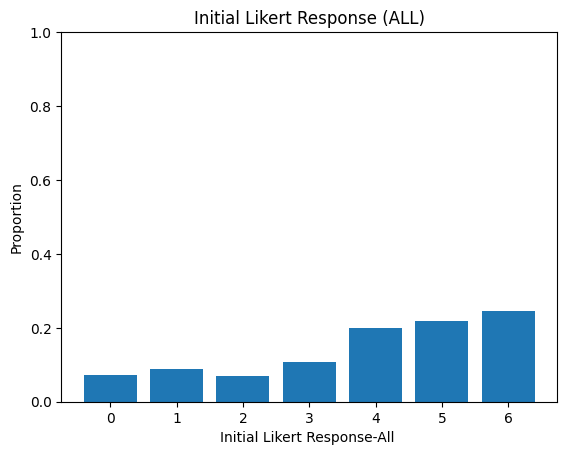

In [ ]:
all_df_player_rounds_ALL = pd.concat([all_df_player_rounds_control, all_df_player_rounds_case], ignore_index=True)

# Assuming 'all_df_player_rounds_ALL' is your DataFrame for the "ALL" data
initial_likert_counts = all_df_player_rounds_ALL['data.value'].value_counts()
mean_initial_likert_counts_ALL = np.mean(all_df_player_rounds_ALL['data.value'])
print("mean_initial_likert_counts_ALL", mean_initial_likert_counts_ALL)

skewness = stats.skew(all_df_player_rounds_ALL['data.value'])
print("Skewness_ALL", skewness)

# Assuming 'plot_bar' is a predefined function that creates bar plots
plot_bar(initial_likert_counts.values, initial_likert_counts.index, 'Initial Likert Response (ALL)', 'Count', 'Initial Likert Response (ALL)', 'Absolute')

num_initial_Likert = all_df_player_rounds_ALL['data.value'].value_counts().sort_index()
num_initial_Likert.index = num_initial_Likert.index.astype(int)
print(num_initial_Likert)
num_initial_Likert_dict = num_initial_Likert.to_dict()

total_responses = len(all_df_player_rounds_ALL['data.value'])
relative_frequency_likert = initial_likert_counts / total_responses

# Plot a bar plot of the initial Likert response distribution based on proportions
plot_bar(relative_frequency_likert.values, relative_frequency_likert.index, 'Initial Likert Response-All ', 'Proportion', 'Initial Likert Response (ALL)', 'relative')

# Convert Likert response counts to a dictionary
likert_counts_dict = relative_frequency_likert.to_dict()
likert_counts_dict = dict(sorted(likert_counts_dict.items()))


### Reasons mentioned by players for change in response

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

def compare_proportions(count_control, total_control, count_case, total_case, alpha=0.05):
    """
    Compare proportions between two groups using a z-test.

    Parameters:
    - count_control: Number of events in the control group.
    - total_control: Total number of observations in the control group.
    - count_case: Number of events in the case group.
    - total_case: Total number of observations in the case group.
    - alpha: Significance level (default is 0.05).

    Returns:
    - result: A string indicating the result of the test.
    """

    # Perform the z-test for proportions
    stat, pval = proportions_ztest([count_control, count_case], [total_control, total_case])

    # Interpret the results
    if pval < alpha:
        result = "The difference in proportions is statistically significant."
        print(result)
    else:
        result = "The difference in proportions is not statistically significant."
        print(result)

    return stat, pval

In [ ]:
from scipy.stats import chi2_contingency

def chi_square_test_for_proportions(count_case, total_case, count_control, total_control, alpha=0.05):
    # Create a contingency table
    contingency_table = np.array([[count_case, total_case - count_case],
                                  [count_control, total_control - count_control]])

    # Perform the Chi-square test for proportions
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

    # Interpret the results
    if p_val < alpha:
        print("The proportions are statistically different.")
    else:
        print("The proportions are not statistically different.")

    return chi2_stat, p_val


In [ ]:
def analyze_reason_updated(df_column):
    total = 0
    change_count = 0
    no_change_count = 0

    for response in df_column:
        if isinstance(response, str) or not math.isnan(response):
            total += 1
            if "peer" in response:
                change_count += 1
            if "I did not change my mind" in response:
                no_change_count += 1

    change_percentage = (change_count / total) * 100
    no_change_percentage = (no_change_count / total) * 100

    print("Out of", total, "responses:")
    print(f"There were {change_count} changes caused by peer responses ({change_percentage:.2f}%)")
    print(f"There were {no_change_count} responses indicating I did not change my mind ({no_change_percentage:.2f}%)")
    return change_count, no_change_count, total

In [ ]:
#count what reasons people gave for updating response

control_reason_updated = all_df_player_rounds_control[
    all_df_player_rounds_control["data.reason_updated"] != all_df_player_rounds_control["data.reason"]
]

case_reason_updated = all_df_player_rounds_case[
    all_df_player_rounds_case["data.reason_updated"] != all_df_player_rounds_case["data.reason"]
]

#print(control_reason_updated)
change_count_control, no_change_count_control, total_control = analyze_reason_updated(control_reason_updated["data.reason_updated"])
change_count_case, no_change_count_case, total_case = analyze_reason_updated(case_reason_updated["data.reason_updated"])



Out of 385 responses:
There were 51 changes caused by peer responses (13.25%)
There were 323 responses indicating I did not change my mind (83.90%)
Out of 398 responses:
There were 66 changes caused by peer responses (16.58%)
There were 302 responses indicating I did not change my mind (75.88%)


In [ ]:
#proportion z-test to check proportion for % changed due to peer response
proportion_z_test, p_val = compare_proportions(change_count_control, total_control, change_count_case, total_case)
print(proportion_z_test, p_val)

##proportion_z_test to check proportion for % who said they did not "change their minds"
proportion_z_test, p_val = compare_proportions(no_change_count_control, total_control, no_change_count_case, total_case)
print(proportion_z_test, p_val)

The difference in proportions is not statistically significant.
-1.3090908276837905 0.1905035858842119
The difference in proportions is statistically significant.
2.7943463588710724 0.005200474595587867


In [ ]:
##CHI Square to check proportion for % changed due to peer response
chi_square_test_for_proportions(change_count_case, total_case, change_count_control, total_control, alpha=0.05)

##CHI Square to check proportion for % who said they did not "change their minds"
chi_square_test_for_proportions(no_change_count_case, total_case, no_change_count_control, total_control, alpha=0.05)

The proportions are not statistically different.
The proportions are statistically different.


(7.318585929400411, 0.0068245088512477155)

Conclusion: proportion that agrees peer response changed their mind is the same, but control has a higher % of "I did not change my mind".

#### Considering only those that changed their minds

In [ ]:
print("control")
change_count_control, no_change_count_control, total_control = analyze_reason_updated(subset_combined_df_changed_answer_control["data.reason_updated"])

print("case")
change_count_case, no_change_count_case, total_case = analyze_reason_updated(subset_combined_df_changed_answer_case["data.reason_updated"])


control
Out of 91 responses:
There were 43 changes caused by peer responses (47.25%)
There were 42 responses indicating I did not change my mind (46.15%)
case
Out of 110 responses:
There were 56 changes caused by peer responses (50.91%)
There were 32 responses indicating I did not change my mind (29.09%)


In [ ]:
#% among those that changed their mind that said that peers changed their mind. THere is no difference between control and case.
proportion_z_test, p_val = compare_proportions(change_count_control, total_control, change_count_case, total_case)
print(proportion_z_test, p_val)

#% that said that they did not change their mind, even when they did. THere is difference between control and case, as it happens less in case.
proportion_z_test, p_val = compare_proportions(no_change_count_control, total_control, no_change_count_case, total_case)
print(proportion_z_test, p_val)

The difference in proportions is not statistically significant.
-0.5161125173285889 0.6057758259465384
The difference in proportions is statistically significant.
2.49661247343729 0.012538589870422492


In [ ]:
##CHI Square to check proportion for % changed due to peer response
chi_square_test_for_proportions(change_count_case, total_case, change_count_control, total_control, alpha=0.05)

##CHI Square to check proportion for % who said they did not "change their minds"
chi_square_test_for_proportions(no_change_count_case, total_case, no_change_count_control, total_control, alpha=0.05)

The proportions are not statistically different.
The proportions are statistically different.


(5.521136729306022, 0.018788046432574246)

###Topic similarity of reasons

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_para(text1, text_list):
    # Create CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the text data for text1
    text1_vector = vectorizer.fit_transform([text1])

    # Transform the text data for text_list
    text_list_vectors = vectorizer.transform(text_list)

    # Calculate cosine similarity for each paragraph in the list
    similarity_list = cosine_similarity(text1_vector, text_list_vectors)[0]
    #print(similarity_list.tolist())
    return similarity_list.tolist()


In [ ]:
def findReason(df, nodeId_array):
  result = []
  nodeId_array = nodeId_array
  #print(nodeId_array)
  for elem in nodeId_array:
    rows = df[df['data.nodeId'] == elem]
    if not rows.empty:
      Likert_value = rows.iloc[0]['data.reason']
      result.append(Likert_value)
  return result

In [ ]:
##For second stage

def ReasonAnalysisControl(network):
    grouped_by_roundId = network.groupby('round_index')
    dfs_by_roundId = {}

    for round_id, group_df in grouped_by_roundId:
        print('round_id', round_id)
        dfs_by_roundId[round_id] = group_df
        dfs_by_roundId[round_id]['social_signal_reason'] = ''
        dfs_by_roundId[round_id]['cosine_similarity_reason'] = ''
        dfs_by_roundId[round_id]['mean_cosine_similarity_reason'] = ''
        dfs_by_roundId[round_id]['max_cosine_similarity_reason'] = ''
        dfs_by_roundId[round_id]['min_cosine_similarity_reason'] = ''

        initial_rows = dfs_by_roundId[round_id].shape[0]

        # Drop rows where 'data.reason' is empty
        dfs_by_roundId[round_id] = dfs_by_roundId[round_id].dropna(subset=['data.reason'])

        # Calculate the number of rows dropped
        dropped_rows = initial_rows - dfs_by_roundId[round_id].shape[0]
        print(f"{dropped_rows} rows were dropped where 'data.reason' is empty.")

        for index, row in dfs_by_roundId[round_id].iterrows():
            if round_id == 0:
                arr = dfs_by_roundId[round_id]['data.base_connections'][index]
            else:
                arr = dfs_by_roundId[round_id]['data.connections'][index]

            if isinstance(arr, str):
                string_array = arr.split(",")
                int_array = [int(x) for x in string_array]
                dfs_by_roundId[round_id].at[index, 'social_signal_reason'] = findReason(dfs_by_roundId[round_id], int_array)
                dfs_by_roundId[round_id].at[index, 'cosine_similarity_reason'] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
                dfs_by_roundId[round_id].at[index,'mean_cosine_similarity_reason'] = np.mean(dfs_by_roundId[round_id]['cosine_similarity_reason'][index])
                dfs_by_roundId[round_id].at[index,'max_cosine_similarity_reason'] = max(dfs_by_roundId[round_id]['cosine_similarity_reason'][index])
                dfs_by_roundId[round_id].at[index,'min_cosine_similarity_reason'] = min(dfs_by_roundId[round_id]['cosine_similarity_reason'][index])

            elif isinstance(arr, float):
                dfs_by_roundId[round_id].at[index,'social_signal_reason'] = [9999]

    return dfs_by_roundId

In [ ]:
all_df_players_network_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 39 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   _id_x                                                         410 non-null    object 
 1   batchId                                                       410 non-null    object 
 2   playerId                                                      410 non-null    object 
 3   roundId                                                       410 non-null    object 
 4   gameId                                                        410 non-null    object 
 5   createdAt_x                                                   410 non-null    object 
 6   data.value                                                    398 non-null    float64
 7   data.value_updated                                            400 non-n

In [ ]:
# Create an empty list to store the resulting DataFrames
grouped_gameId = all_df_players_network_control.groupby('gameId')
df_networks_social = []
combine_df_dict_control = []

# Iterate over the groups
for group_value, group_df in grouped_gameId:
    # Append each group DataFrame to the list
    df_networks_social.append(group_df)
    print(len(group_df)/5)

for i in range(len(df_networks_social)):
    result = ReasonAnalysisControl(df_networks_social[i])
    combine_df_dict_control.append(result)

combined_df_control = combine_dictionaries_df(*combine_df_dict_control)
combined_df_control.info()



8.0
13.0
30.0
14.0
17.0
round_id 0
0 rows were dropped where 'data.reason' is empty.
round_id 1
0 rows were dropped where 'data.reason' is empty.
round_id 2
0 rows were dropped where 'data.reason' is empty.
round_id 3
0 rows were dropped where 'data.reason' is empty.
round_id 4
0 rows were dropped where 'data.reason' is empty.
round_id 0
0 rows were dropped where 'data.reason' is empty.
round_id 1
0 rows were dropped where 'data.reason' is empty.
round_id 2
2 rows were dropped where 'data.reason' is empty.
round_id 3
3 rows were dropped where 'data.reason' is empty.
round_id 4
1 rows were dropped where 'data.reason' is empty.
round_id 0
9 rows were dropped where 'data.reason' is empty.
round_id 1
7 rows were dropped where 'data.reason' is empty.
round_id 2
6 rows were dropped where 'data.reason' is empty.
round_id 3
4 rows were dropped where 'data.reason' is empty.
round_id 4
5 rows were dropped where 'data.reason' is empty.
round_id 0
0 rows were dropped where 'data.reason' is empty.


In [ ]:
def ReasonAnalysisCase(network):
    grouped_by_roundId = network.groupby('round_index')
    dfs_by_roundId = {}

    for round_id, group_df in grouped_by_roundId:
        print('round_id', round_id)
        dfs_by_roundId[round_id] = group_df
        dfs_by_roundId[round_id]['social_signal_reason'] = ''
        dfs_by_roundId[round_id]['cosine_similarity_reason'] = ''
        dfs_by_roundId[round_id]['mean_cosine_similarity_reason'] = ''
        dfs_by_roundId[round_id]['max_cosine_similarity_reason'] = ''
        dfs_by_roundId[round_id]['min_cosine_similarity_reason'] = ''

        # Drop rows where 'data.reason' is empty
        dfs_by_roundId[round_id] = dfs_by_roundId[round_id].dropna(subset=['data.reason'])

        for index, row in dfs_by_roundId[round_id].iterrows():
            arr = dfs_by_roundId[round_id]['data.s1recs1sim2ran'][index]
            if isinstance(arr, str):
                string_array = arr.split(",")
                int_array = [int(x) for x in string_array]
                dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
                dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
                dfs_by_roundId[round_id]['mean_cosine_similarity_reason'][index] = np.mean(dfs_by_roundId[round_id]['cosine_similarity_reason'][index])
                dfs_by_roundId[round_id]['max_cosine_similarity_reason'][index] = max(dfs_by_roundId[round_id]['cosine_similarity_reason'][index])
                dfs_by_roundId[round_id]['min_cosine_similarity_reason'][index] = min(dfs_by_roundId[round_id]['cosine_similarity_reason'][index])
            elif isinstance(arr, float):
                dfs_by_roundId[round_id]['social_signal_reason'][index] = [9999]

    return dfs_by_roundId


In [ ]:
# Create an empty list to store the resulting DataFrames
grouped_gameId = all_df_players_network_case.groupby('gameId')
df_networks_social = []
combine_df_dict = []

# Iterate over the groups
for group_value, group_df in grouped_gameId:
    # Append each group DataFrame to the list
    df_networks_social.append(group_df)

for i in range(len(df_networks_social)):
    result = ReasonAnalysisCase(df_networks_social[i])
    combine_df_dict.append(result)

combined_df_case = combine_dictionaries_df(*combine_df_dict)
combined_df_case.info()


round_id 0
round_id 1
round_id 2


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 3
round_id 4
round_id 0


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 1
round_id 2


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 3
round_id 4


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 0
round_id 1
round_id 2


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 3
round_id 4
round_id 0


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 1
round_id 2
round_id 3


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 4
round_id 0


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 1
round_id 2


<ipython-input-52-d93a17ce0773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['social_signal_reason'][index] = findReason(dfs_by_roundId[round_id], int_array)
<ipython-input-52-d93a17ce0773>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_roundId[round_id]['cosine_similarity_reason'][index] = cosine_similarity_para(dfs_by_roundId[round_id]['data.reason'][index], dfs_by_roundId[round_id]['social_signal_reason'][index])
<ipython-input-52-d93a17ce0773>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

round_id 3
round_id 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 45 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   _id_x                                           381 non-null    object 
 1   batchId                                         381 non-null    object 
 2   playerId                                        381 non-null    object 
 3   roundId                                         381 non-null    object 
 4   gameId                                          381 non-null    object 
 5   createdAt_x                                     381 non-null    object 
 6   data.value                                      381 non-null    float64
 7   data.value_updated                              381 non-null    float64
 8   data.reason                                     381 non-null    object 
 9   data.reason_updated  

###Second stage analysis - reason

In [ ]:
subset_combined_df_changed_answer_control = combined_df_control[combined_df_control['data.difference_likert'] != 0]
subset_combined_df_unchanged_answer_control = combined_df_control[combined_df_control['data.difference_likert'] == 0]

subset_combined_df_changed_answer_control['mean_cosine_similarity_reason'] = pd.to_numeric(subset_combined_df_changed_answer_control['mean_cosine_similarity_reason'], errors='coerce')
subset_combined_df_changed_answer_control.dropna(subset=['mean_cosine_similarity_reason'], inplace=True)

subset_combined_df_unchanged_answer_control['mean_cosine_similarity_reason'] = pd.to_numeric(subset_combined_df_unchanged_answer_control['mean_cosine_similarity_reason'], errors='coerce')
subset_combined_df_unchanged_answer_control.dropna(subset=['mean_cosine_similarity_reason'], inplace=True)


<ipython-input-54-8491ceca419c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_combined_df_changed_answer_control['mean_cosine_similarity_reason'] = pd.to_numeric(subset_combined_df_changed_answer_control['mean_cosine_similarity_reason'], errors='coerce')
<ipython-input-54-8491ceca419c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_combined_df_changed_answer_control.dropna(subset=['mean_cosine_similarity_reason'], inplace=True)
<ipython-input-54-8491ceca419c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
# Calculate means
mean_changed_control = subset_combined_df_changed_answer_control['mean_cosine_similarity_reason'].mean()
mean_unchanged_control = subset_combined_df_unchanged_answer_control['mean_cosine_similarity_reason'].mean()

# Perform independent t-test
t_statistic, p_value = ttest_ind(subset_combined_df_changed_answer_control['mean_cosine_similarity_reason'], subset_combined_df_unchanged_answer_control['mean_cosine_similarity_reason'])

# Print means
print(f"Mean (Changed): {mean_changed_control:.2f}")
print(f"Mean (Unchanged): {mean_unchanged_control:.2f}")

# Print statistical analysis
print("Independent t-test:")
print(f"t-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

# Determine significance
alpha = 0.05
if p_value < alpha:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")

Mean (Changed): 0.41
Mean (Unchanged): 0.42
Independent t-test:
t-statistic: -0.42
P-value: 0.6730
The difference in means is not statistically significant.


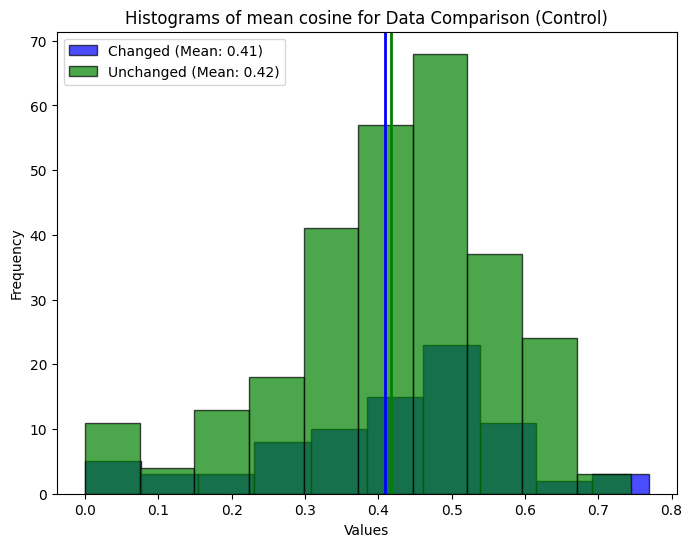

In [ ]:
# Create histograms
plt.figure(figsize=(8, 6))
# Calculate and plot mean lines
mean_changed_control = subset_combined_df_changed_answer_control['mean_cosine_similarity_reason'].mean()
mean_unchanged_control = subset_combined_df_unchanged_answer_control['mean_cosine_similarity_reason'].mean()


plt.hist(subset_combined_df_changed_answer_control['mean_cosine_similarity_reason'], bins=10, alpha=0.7, label=f'Changed (Mean: {mean_changed_control:.2f})', color='blue', edgecolor='black')
plt.hist(subset_combined_df_unchanged_answer_control['mean_cosine_similarity_reason'], bins=10, alpha=0.7, label=f'Unchanged (Mean: {mean_unchanged_control:.2f})', color='green', edgecolor='black')

plt.axvline(mean_changed_control, color='blue', linestyle='-', linewidth=2)
plt.axvline(mean_unchanged_control, color='green', linestyle='-', linewidth=2)

# Add labels and title
plt.title('Histograms of mean cosine for Data Comparison (Control)')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
#MEAN
subset_combined_df_changed_answer_case = combined_df_case[combined_df_case['data.difference_likert'] != 0]
subset_combined_df_unchanged_answer_case = combined_df_case[combined_df_case['data.difference_likert'] == 0]

subset_combined_df_changed_answer_case['mean_cosine_similarity_reason'] = pd.to_numeric(subset_combined_df_changed_answer_case['mean_cosine_similarity_reason'], errors='coerce')
# Drop rows with NaN values in the specified column
subset_combined_df_changed_answer_case.dropna(subset=['mean_cosine_similarity_reason'], inplace=True)

subset_combined_df_unchanged_answer_case['mean_cosine_similarity_reason'] = pd.to_numeric(subset_combined_df_unchanged_answer_case['mean_cosine_similarity_reason'], errors='coerce')
# Drop rows with NaN values in the specified column
subset_combined_df_unchanged_answer_case.dropna(subset=['mean_cosine_similarity_reason'], inplace=True)

<ipython-input-57-fcfb2576e6e2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_combined_df_changed_answer_case['mean_cosine_similarity_reason'] = pd.to_numeric(subset_combined_df_changed_answer_case['mean_cosine_similarity_reason'], errors='coerce')
<ipython-input-57-fcfb2576e6e2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_combined_df_changed_answer_case.dropna(subset=['mean_cosine_similarity_reason'], inplace=True)
<ipython-input-57-fcfb2576e6e2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [ ]:
# Calculate means
mean_changed_case = subset_combined_df_changed_answer_case['mean_cosine_similarity_reason'].mean()
mean_unchanged_case = subset_combined_df_unchanged_answer_case['mean_cosine_similarity_reason'].mean()

# Perform independent t-test
t_statistic, p_value = ttest_ind(subset_combined_df_changed_answer_case['mean_cosine_similarity_reason'], subset_combined_df_unchanged_answer_case['mean_cosine_similarity_reason'])

# Print means
print(f"Mean (Changed): {mean_changed_case:.2f}")
print(f"Mean (Unchanged): {mean_unchanged_case:.2f}")

# Print statistical analysis
print("Independent t-test:")
print(f"t-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

# Determine significance
alpha = 0.05
if p_value < alpha:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")

Mean (Changed): 0.41
Mean (Unchanged): 0.42
Independent t-test:
t-statistic: -0.49
P-value: 0.6247
The difference in means is not statistically significant.


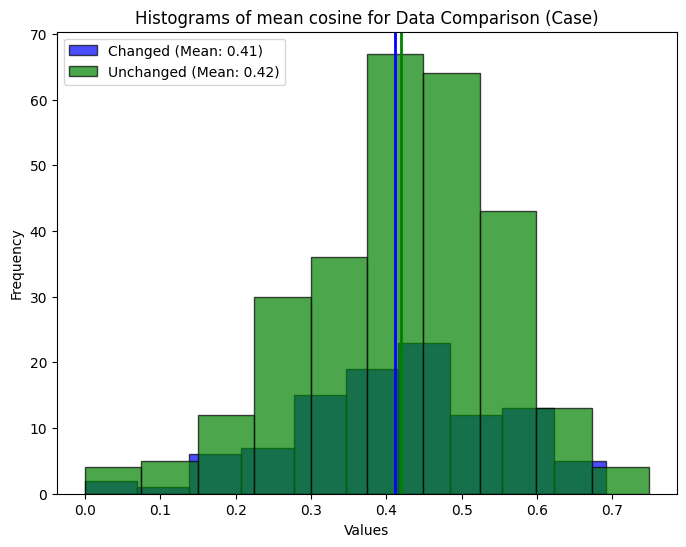

In [ ]:
# Calculate and plot mean lines
mean_changed_case = subset_combined_df_changed_answer_case['mean_cosine_similarity_reason'].mean()
mean_unchanged_case = subset_combined_df_unchanged_answer_case['mean_cosine_similarity_reason'].mean()
plt.figure(figsize=(8, 6))
plt.hist(subset_combined_df_changed_answer_case['mean_cosine_similarity_reason'], bins=10, alpha=0.7, label=f'Changed (Mean: {mean_changed_control:.2f})', color='blue', edgecolor='black')
plt.hist(subset_combined_df_unchanged_answer_case['mean_cosine_similarity_reason'], bins=10, alpha=0.7, label=f'Unchanged (Mean: {mean_unchanged_control:.2f})', color='green', edgecolor='black')


plt.axvline(mean_changed_case, color='blue', linestyle='-', linewidth=2)
plt.axvline(mean_unchanged_case, color='green', linestyle='-', linewidth=2)

# Add labels and title
plt.title('Histograms of mean cosine for Data Comparison (Case)')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show legend
plt.legend()

# Show the plot
plt.show()


###Third stage analysis - reason

In [ ]:
def ThirdStageReasonAnalysis(network):
    def calculate_notfollowed(total_recommendations, followed_players):
      try:
          total_recommendations_list = list(map(int, total_recommendations.split(',')))
      except ValueError:
          # Handle cases where conversion to integer fails
          total_recommendations_list = []
      try:
          followed_players_list = list(map(int, followed_players.split(',')))
      except ValueError:
          # Handle cases where conversion to integer fails
          followed_players_list = []
      # Calculate notfollowed using set difference
      notfollowed = list(set(total_recommendations_list) - set(followed_players_list))
      return notfollowed

    # Initialize empty dictionary to store DataFrames
    dfs_by_roundId = {}

    for round_id, group_df in network.groupby('round_index'):
        print('round_id', round_id)

        # Initialize new columns with default values
        columns_to_add = ['third_stage_social_signal_reason_followed',
                          'third_stage_cosine_similarity_reason_followed',
                          'third_stage_mean_cosine_similarity_reason_followed',
                          'third_stage_max_cosine_similarity_reason_followed',
                          'third_stage_min_cosine_similarity_reason_followed',
                          'third_stage_social_signal_reason_notfollowed',
                          'third_stage_cosine_similarity_reason_notfollowed',
                          'third_stage_mean_cosine_similarity_reason_notfollowed',
                          'third_stage_max_cosine_similarity_reason_notfollowed'
                          'third_stage_min_cosine_similarity_reason_notfollowed']
        for col in columns_to_add:
            group_df[col] = ''

        # Drop rows where 'data.reason' is empty
        group_df = group_df.dropna(subset=['data.reason'])
        group_df = group_df.dropna(subset=['data.followedPlayers'])
        group_df = group_df.dropna(subset=['data.player_specific_total_recommendation_list'])

        for index, row in group_df.iterrows():
            # Process 'data.player_specific_total_recommendation_list' and 'data.followedPlayers'
            #total_recommendations = pd.to_numeric(row['data.player_specific_total_recommendation_list'], errors='coerce')
            #followed_players = pd.to_numeric(row['data.followedPlayers'], errors='coerce')
            total_recommendations = row['data.player_specific_total_recommendation_list']
            followed_players = row['data.followedPlayers']
            arr_followed = followed_players
            #print("followed_players", arr_followed)
            # Calculate arrays for followed and notfollowed
            arr_notfollowed = calculate_notfollowed(total_recommendations, followed_players)
            #print("arr_notfollowed", arr_notfollowed)
            arr_notfollowed = ", ".join(map(str, arr_notfollowed))
            #arr_followed = followed_players

            # Process for FOLLOWED
            if isinstance(arr_followed, str):
                int_array = list(map(int, arr_followed.split(",")))
                #print("followed", int_array)
                social_signal = findReason(group_df, int_array)
                cosine_sim = cosine_similarity_para(row['data.reason'], social_signal)

                group_df.at[index, 'third_stage_social_signal_reason_followed'] = social_signal
                group_df.at[index, 'third_stage_cosine_similarity_reason_followed'] = cosine_sim
                group_df.at[index, 'third_stage_mean_cosine_similarity_reason_followed'] = np.mean(cosine_sim)
                group_df.at[index, 'third_stage_max_cosine_similarity_reason_followed'] = max(cosine_sim)
                group_df.at[index, 'third_stage_min_cosine_similarity_reason_followed'] = min(cosine_sim)

            if arr_notfollowed:
                int_array = list(map(int, arr_notfollowed.split(",")))
                social_signal_notfollowed = findReason(group_df, int_array)
                #print(social_signal_notfollowed)
                if social_signal_notfollowed:
                  cosine_sim_notfollowed = cosine_similarity_para(row['data.reason'], social_signal_notfollowed)
                  group_df.at[index, 'third_stage_social_signal_reason_notfollowed'] = social_signal_notfollowed
                  group_df.at[index, 'third_stage_cosine_similarity_reason_notfollowed'] = cosine_sim_notfollowed
                  group_df.at[index, 'third_stage_mean_cosine_similarity_reason_notfollowed'] = np.mean(cosine_sim_notfollowed)
                  group_df.at[index, 'third_stage_max_cosine_similarity_reason_notfollowed'] = max(cosine_sim_notfollowed)
                  group_df.at[index, 'third_stage_min_cosine_similarity_reason_notfollowed'] = min(cosine_sim_notfollowed)

        # Store the modified DataFrame
        dfs_by_roundId[round_id] = group_df

    return dfs_by_roundId


In [ ]:
# Group the combined_df by 'gameId'
grouped_gameId = all_df_players_network_control.groupby('gameId')

# Process each group and store the result
combine_df_dict_control = []
for game_id, group_df in grouped_gameId:
    print(f"Processing gameId: {game_id}")
    result = ThirdStageReasonAnalysis(group_df)
    combine_df_dict_control.append(result)

# Combine the results
combined_df_control = combine_dictionaries_df(*combine_df_dict_control)
combined_df_control.info()

Processing gameId: 8b8dTFpeaiTPFp7Zm
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
Processing gameId: DQQizT4TbeotZGD2f
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
Processing gameId: Js68w3jJb3e72Gpyj
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
Processing gameId: cuTqv6xdGJfdaPmwM
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
Processing gameId: kYgjq882HsZb7F7jA
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 50 columns):
 #   Column                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                    --------------  -----  
 0   _id_x                                                                                                     355 non-null    object 
 1   batchId                  

In [ ]:
# Group the combined_df by 'gameId'
grouped_gameId = all_df_players_network_case.groupby('gameId')

# Process each group and store the result
combine_df_dict_case = []
for game_id, group_df in grouped_gameId:
    print(f"Processing gameId: {game_id}")
    result = ThirdStageReasonAnalysis(group_df)
    combine_df_dict_case.append(result)

# Combine the results
combined_df_case = combine_dictionaries_df(*combine_df_dict_case)
combined_df_case.info()

Processing gameId: CG7cWa4QWvsG9nxMu
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
Processing gameId: iQgq9We48TWLZPXjh
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
Processing gameId: pA8QEvxkstWdRQeAh
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
Processing gameId: quFcEyR6pyBDjQeRj
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
Processing gameId: xzjPTkZ6udh5nRa6Y
round_id 0
round_id 1
round_id 2
round_id 3
round_id 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 51 columns):
 #   Column                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                    --------------  -----  
 0   _id_x                                                                                                     380 non-null    object 
 1   batchId                  

mean_followed_control 0.42423105127738486
mean_not_followed_control 0.3761218921497182


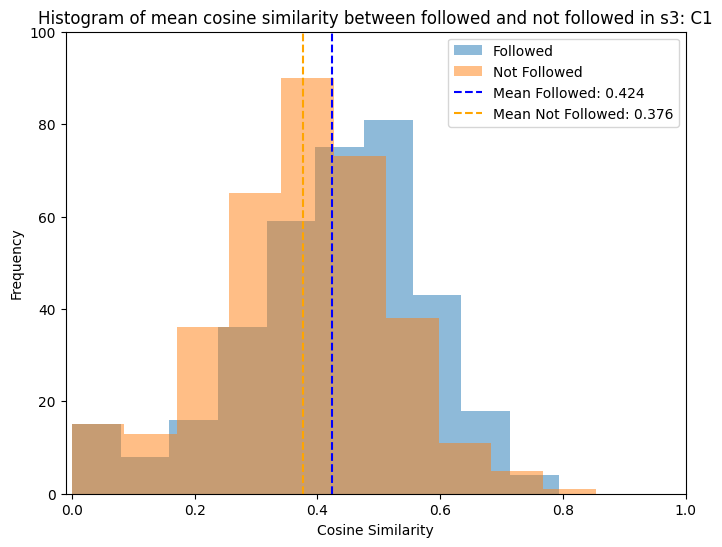

'Statistics=75219.500, p=0.000. Different distribution (reject H0)'

In [ ]:
combined_df_control["third_stage_mean_cosine_similarity_reason_followed"] = pd.to_numeric(combined_df_control["third_stage_mean_cosine_similarity_reason_followed"], errors='coerce')
combined_df_control["third_stage_mean_cosine_similarity_reason_notfollowed"] = pd.to_numeric(combined_df_control["third_stage_mean_cosine_similarity_reason_notfollowed"], errors='coerce')

# Calculate means
mean_followed_control = combined_df_control["third_stage_mean_cosine_similarity_reason_followed"].mean()
mean_not_followed_control = combined_df_control["third_stage_mean_cosine_similarity_reason_notfollowed"].mean()
print('mean_followed_control', mean_followed_control)
print('mean_not_followed_control', mean_not_followed_control)

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(combined_df_control["third_stage_mean_cosine_similarity_reason_followed"].dropna(), alpha=0.5, label='Followed')
plt.hist(combined_df_control["third_stage_mean_cosine_similarity_reason_notfollowed"].dropna(), alpha=0.5, label='Not Followed')
plt.ylim(0,100)
plt.xlim(-0.01,1)

# Add lines for means
plt.axvline(x=mean_followed_control, color='blue', linestyle='--', label=f'Mean Followed: {mean_followed_control:.3f}')
plt.axvline(x=mean_not_followed_control, color='orange', linestyle='--', label=f'Mean Not Followed: {mean_not_followed_control:.3f}')

# # Adjusting text for means on the plot to reflect the lines addition
# plt.text(x=0.95, y=0.85, s=f"Mean Followed: {mean_followed_control:.3f}", transform=plt.gca().transAxes, horizontalalignment='right', fontsize=10, color='blue')
# plt.text(x=0.95, y=0.80, s=f"Mean Not Followed: {mean_not_followed_control:.3f}", transform=plt.gca().transAxes, horizontalalignment='right', fontsize=10, color='orange')

# Add labels and title
plt.title('Histogram of mean cosine similarity between followed and not followed in s3: C1')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Show legend
plt.legend()
plt.show()

mann_whitney_test(combined_df_control, 'third_stage_mean_cosine_similarity_reason_followed', combined_df_control, 'third_stage_mean_cosine_similarity_reason_notfollowed')


mean_followed_case 0.4510064337703779
mean_not_followed_case 0.4035992932465265


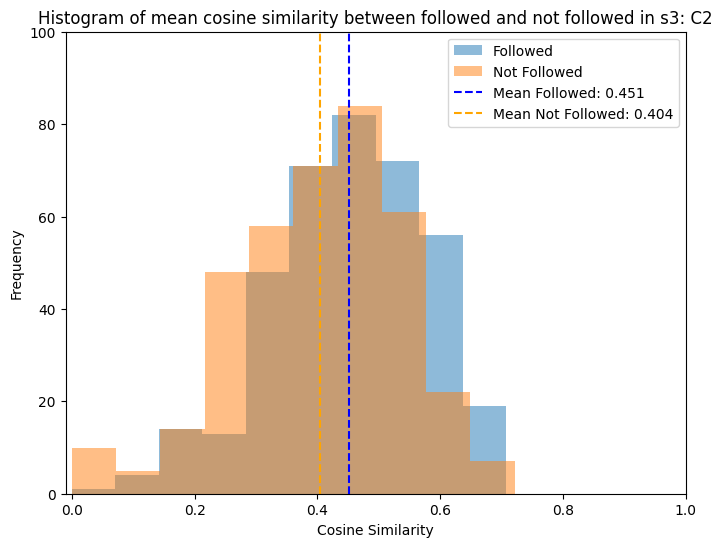

'Statistics=86575.500, p=0.000. Different distribution (reject H0)'

In [ ]:

# Assuming combined_df_case is already defined and contains the necessary data
combined_df_case["third_stage_mean_cosine_similarity_reason_followed"] = pd.to_numeric(combined_df_case["third_stage_mean_cosine_similarity_reason_followed"], errors='coerce')
combined_df_case["third_stage_mean_cosine_similarity_reason_notfollowed"] = pd.to_numeric(combined_df_case["third_stage_mean_cosine_similarity_reason_notfollowed"], errors='coerce')

# Calculate means for the case group
mean_followed_case = combined_df_case["third_stage_mean_cosine_similarity_reason_followed"].mean()
mean_not_followed_case = combined_df_case["third_stage_mean_cosine_similarity_reason_notfollowed"].mean()
print('mean_followed_case', mean_followed_case)
print('mean_not_followed_case', mean_not_followed_case)

# Plotting the histogram for the case group
plt.figure(figsize=(8, 6))
plt.hist(combined_df_case["third_stage_mean_cosine_similarity_reason_followed"].dropna(), alpha=0.5, label='Followed')
plt.hist(combined_df_case["third_stage_mean_cosine_similarity_reason_notfollowed"].dropna(), alpha=0.5, label='Not Followed')
plt.ylim(0,100)
plt.xlim(-0.01,1)

# Add lines for means for the case group
plt.axvline(x=mean_followed_case, color='blue', linestyle='--', label=f'Mean Followed: {mean_followed_case:.3f}')
plt.axvline(x=mean_not_followed_case, color='orange', linestyle='--', label=f'Mean Not Followed: {mean_not_followed_case:.3f}')

# Add labels and title for the case group
plt.title('Histogram of mean cosine similarity between followed and not followed in s3: C2')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Show legend
plt.legend()
plt.show()

mann_whitney_test(combined_df_case, 'third_stage_mean_cosine_similarity_reason_followed', combined_df_case, 'third_stage_mean_cosine_similarity_reason_notfollowed')


In [ ]:
print(mann_whitney_test(combined_df_control, 'third_stage_mean_cosine_similarity_reason_followed', combined_df_case, 'third_stage_mean_cosine_similarity_reason_followed'))
print(mann_whitney_test(combined_df_control, 'third_stage_mean_cosine_similarity_reason_notfollowed', combined_df_case, 'third_stage_mean_cosine_similarity_reason_notfollowed'))

#Note so they are all different distribution

Statistics=61763.500, p=0.048. Different distribution (reject H0)
Statistics=57723.000, p=0.004. Different distribution (reject H0)


In [ ]:
# Perform independent t-test
t_statistic, p_value = ttest_ind(combined_df_control['third_stage_mean_cosine_similarity_reason_followed'], combined_df_case['third_stage_mean_cosine_similarity_reason_followed'], equal_var=False)

print(f"Independent t-test. t-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.4f}")

# Determine significance
alpha = 0.05
if p_value < alpha:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")

Independent t-test. t-statistic: -2.532
P-value: 0.0116
The difference in means is statistically significant.


In [ ]:
print("mean_followed_control", mean_followed_control)
print("mean_not_followed_control", mean_not_followed_control)

print("mean_followed_case", mean_followed_case)
print("mean_not_followed_case", mean_not_followed_case)
print("")
# mean_followed_case mean_not_followed_case

#checking difference between followed and unfollowed in control
t_statistic, p_value = ttest_ind(combined_df_control['third_stage_mean_cosine_similarity_reason_followed'].dropna(), combined_df_control["third_stage_mean_cosine_similarity_reason_notfollowed"].dropna(), equal_var=False)
print(f"Independent t-test. t-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value}")
print("")
#checking difference between followed and unfollowed in case
t_statistic, p_value = ttest_ind(combined_df_case['third_stage_mean_cosine_similarity_reason_followed'], combined_df_case['third_stage_mean_cosine_similarity_reason_notfollowed'], equal_var=False)
print(f"Independent t-test. t-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value}")
print("")
#checking difference between followed in case and control
t_statistic, p_value = ttest_ind(combined_df_control['third_stage_mean_cosine_similarity_reason_followed'], combined_df_case['third_stage_mean_cosine_similarity_reason_followed'], equal_var=False)
print(f"Independent t-test. t-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value}")
print("")

#checking difference between unfollowed in case and control
t_statistic, p_value = ttest_ind(combined_df_control['third_stage_mean_cosine_similarity_reason_notfollowed'].dropna(), combined_df_case['third_stage_mean_cosine_similarity_reason_notfollowed'].dropna(), equal_var=False)
print(f"Independent t-test. t-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value}")
print("")

mean_followed_control 0.42423105127738486
mean_not_followed_control 0.3761218921497182
mean_followed_case 0.4510064337703779
mean_not_followed_case 0.4035992932465265

Independent t-test. t-statistic: 4.246
P-value: 2.4732078792072262e-05

Independent t-test. t-statistic: 4.939
P-value: 9.661408885967068e-07

Independent t-test. t-statistic: -2.532
P-value: 0.011562601657147368

Independent t-test. t-statistic: -2.636
P-value: 0.008582022950270728



##Third stage network belief distance

In [ ]:
def findThirdFollows(df, nodeId_array):
  result = []
  nodeId_array = nodeId_array
  #print(nodeId_array)
  for elem in nodeId_array:
    rows = df[df['data.nodeId'] == elem]
    if not rows.empty:
      Likert_value = rows.iloc[0]['data.value']
      result.append(Likert_value)
  return result

In [ ]:
def thirdStageFollowAnalysis(network):
    grouped_by_roundId = network.groupby('round_index')
    dfs_by_roundId = {}

    for round_id, group_df in grouped_by_roundId:
        dfs_by_roundId[round_id] = group_df

        dfs_by_roundId[round_id]['third_stage_total_signal_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert_diff_initial'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert_diff_updated'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert_diff_initial_abs'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert_diff_updated_abs'] = ''

        dfs_by_roundId[round_id]['third_stage_social_signal_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_initial'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_updated'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_initial_abs'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert_diff_updated_abs'] = ''
        dfs_by_roundId[round_id]['third_stage_not_followed_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert_diff_initial'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert_diff_updated'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert_diff_initial_abs'] = ''
        dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert_diff_updated_abs'] = ''

        for index, row in dfs_by_roundId[round_id].iterrows():
            arr_total_rec = dfs_by_roundId[round_id]['data.player_specific_total_recommendation_list'][index]
            arr_followed = dfs_by_roundId[round_id]['data.followedPlayers'][index]
            print(arr_total_rec)
            print(arr_followed)

            if isinstance(arr_total_rec, str):
                total_rec_array = [int(x) for x in arr_total_rec.split(",")]
                dfs_by_roundId[round_id].at[index, 'third_stage_total_signal_Likert'] = findThirdFollows(dfs_by_roundId[round_id], total_rec_array)
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_total_signal_Likert'] = np.mean(dfs_by_roundId[round_id]['third_stage_total_signal_Likert'][index])
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_total_signal_Likert_diff_initial'] = dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value'][index]

                #initial absolute
                mean_third_stage_total_signal_Likert_diff_initial_abs =  dfs_by_roundId[round_id].at[index, 'third_stage_total_signal_Likert'] - dfs_by_roundId[round_id]['data.value'][index]
                absolute_list_total_rec = [abs(number) for number in mean_third_stage_total_signal_Likert_diff_initial_abs]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_total_signal_Likert_diff_initial_abs'] = np.mean(absolute_list_total_rec)

                #updated
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_total_signal_Likert_diff_updated'] = dfs_by_roundId[round_id]['mean_third_stage_total_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value_updated'][index]
                #updated absolute
                absolute_list_total_rec_updated = dfs_by_roundId[round_id]['third_stage_total_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value_updated'][index]
                absolute_list_total_rec_updated = [abs(number) for number in absolute_list_total_rec_updated]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_total_signal_Likert_diff_updated_abs'] = np.mean(absolute_list_total_rec_updated)

            elif isinstance(arr_total_rec, float):
                dfs_by_roundId[round_id].at[index, 'third_stage_total_signal_Likert'] = [9999]

            if isinstance(arr_followed, str):
                followed_array = [int(x) for x in arr_followed.split(",")]
                third_stage_social_signal_Likert = findThirdFollows(dfs_by_roundId[round_id], followed_array)
                dfs_by_roundId[round_id].at[index, 'third_stage_social_signal_Likert'] = third_stage_social_signal_Likert
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert'] = np.mean(dfs_by_roundId[round_id]['third_stage_social_signal_Likert'][index])
                mean_third_stage_social_signal_diff_initial_Likert = dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value'][index]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert_diff_initial'] = mean_third_stage_social_signal_diff_initial_Likert

                #initial absolute
                mean_third_stage_social_signal_Likert_diff_initial_abs = dfs_by_roundId[round_id].at[index, 'third_stage_social_signal_Likert'] - dfs_by_roundId[round_id]['data.value'][index]
                mean_third_stage_social_signal_Likert_diff_initial_abs = [abs(number) for number in mean_third_stage_social_signal_Likert_diff_initial_abs]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert_diff_initial_abs'] = np.mean(mean_third_stage_social_signal_Likert_diff_initial_abs)

                #updated
                mean_third_stage_social_signal_diff_updated_Likert = dfs_by_roundId[round_id]['mean_third_stage_social_signal_Likert'][index] - dfs_by_roundId[round_id]['data.value_updated'][index]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert_diff_updated'] = mean_third_stage_social_signal_diff_updated_Likert

                #updated absolute
                mean_third_stage_social_signal_Likert_diff_updated_abs = dfs_by_roundId[round_id].at[index, 'third_stage_social_signal_Likert'] - dfs_by_roundId[round_id]['data.value_updated'][index]
                mean_third_stage_social_signal_Likert_diff_updated_abs = [abs(number) for number in mean_third_stage_social_signal_Likert_diff_updated_abs]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_social_signal_Likert_diff_updated_abs'] = np.mean(mean_third_stage_social_signal_Likert_diff_updated_abs)

            elif isinstance(arr_followed, float):
                dfs_by_roundId[round_id].at[index, 'third_stage_social_signal_Likert'] = [9999]

            arr_not_followed = [player for player in total_rec_array if player not in followed_array]
            print(arr_not_followed)
            if arr_not_followed:  # If arr_not_followed is not empty
                third_stage_not_followed_Likert = findThirdFollows(dfs_by_roundId[round_id], arr_not_followed)
                dfs_by_roundId[round_id].at[index, 'third_stage_not_followed_Likert'] = third_stage_not_followed_Likert
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert'] = np.mean(third_stage_not_followed_Likert)

                mean_third_stage_not_followed_diff_initial_Likert = dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert'][index] - dfs_by_roundId[round_id]['data.value'][index]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert_diff_initial'] = mean_third_stage_not_followed_diff_initial_Likert

                #initial absolute
                mean_third_stage_not_followed_Likert_diff_initial_abs = dfs_by_roundId[round_id].at[index, 'third_stage_not_followed_Likert'] - dfs_by_roundId[round_id]['data.value'][index]
                mean_third_stage_not_followed_Likert_diff_initial_abs = [abs(number) for number in mean_third_stage_not_followed_Likert_diff_initial_abs]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert_diff_initial_abs'] = np.mean(mean_third_stage_not_followed_Likert_diff_initial_abs)


                #updated
                mean_third_stage_not_followed_diff_updated_Likert = dfs_by_roundId[round_id]['mean_third_stage_not_followed_Likert'][index] - dfs_by_roundId[round_id]['data.value_updated'][index]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert_diff_updated'] = mean_third_stage_not_followed_diff_updated_Likert

                #updated absolute
                mean_third_stage_not_followed_Likert_diff_updated_abs = dfs_by_roundId[round_id].at[index, 'third_stage_not_followed_Likert'] - dfs_by_roundId[round_id]['data.value_updated'][index]
                mean_third_stage_not_followed_Likert_diff_updated_abs = [abs(number) for number in mean_third_stage_not_followed_Likert_diff_updated_abs]
                dfs_by_roundId[round_id].at[index, 'mean_third_stage_not_followed_Likert_diff_updated_abs'] = np.mean(mean_third_stage_not_followed_Likert_diff_updated_abs)
    return dfs_by_roundId

In [ ]:
# Create an empty list to store the resulting DataFrames
grouped_gameId = all_df_players_network_control.groupby('gameId')
df_networks = []
combine_df_dict = []

# Iterate over the groups
for group_value, group_df in grouped_gameId:
    # Append each group DataFrame to the list
    df_networks.append(group_df)

for i in range(len(df_networks)):
    result = thirdStageFollowAnalysis(df_networks[i])
    combine_df_dict.append(result)

print(len(combine_df_dict))
combined_df_control = combine_dictionaries_df(*combine_df_dict)
combined_df_control.info()

2,3,1,5,4,6
1,3,2
[5, 4, 6]
2,5,0,4,6,3
3,4,2
[5, 0, 6]
0,7,1,3,5,4
7,0,5
[1, 3, 4]
0,4,5,7,1,2
4,1,2
[0, 5, 7]
0,3,2,5,7
5,3,7
[0, 2]
4,2,7,0,1
0,1,7
[4, 2]
0,1,3
0,3,1
[]
2,5,1,4,3,0
2,3,4
[5, 1, 0]
5,4,6,1,2,3
1,2,4
[5, 6, 3]
4,3,5,0,2,6
4,2,0
[3, 5, 6]
7,5,4,0,3,1
7,0,5
[4, 3, 1]
6,4,2,0,1,5
4,1,2
[6, 0, 5]
2,5,3,0,1,7
5,7,2
[3, 0, 1]
2,0,4,1,3,7
0,1,7
[2, 4, 3]
4,1,3,5,0,2
0,3,4
[1, 5, 2]
1,3,0,5,4,2
2,3,4
[1, 0, 5]
5,3,2,1,4,6
1,6,2
[5, 3, 4]
3,5,2,4,6,0
0,6,5
[3, 2, 4]
3,4,7,1,0,5
5,4,7
[3, 1, 0]
0,4,5,2,1,6
4,1,2
[0, 5, 6]
3,1,0,5,7,2
5,7,2
[3, 1, 0]
1,0,6,4,7
0,1,7
[6, 4]
0,7,4,3,5
0,4,5
[7, 3]
3,5,0,2,6,4
2,3,4
[5, 0, 6]
2,5,6,1,3,4
1,3,4
[2, 5, 6]
3,4,5,7,0,6
0,7,4
[3, 5, 6]
0,7,4,5,3,6
0,3,6
[7, 4, 5]
7,0,2,4,1,5
4,1,2
[7, 0, 5]
3,2,0,1,7,5
7,3,0
[2, 1, 5]
2,3,4,0,7,1
0,1,7
[2, 3, 4]
2,3,0,5,1,4
4,5,2
[3, 0, 1]
3,2,1,0,4,5
2,3,4
[1, 0, 5]
7,1,3,6,4,5
1,3,4
[7, 6, 5]
5,4,0,7,3,2
4,3,2
[5, 0, 7]
3,1,5,6,0,4
0,3,6
[1, 5, 4]
5,7,4,1,0,2
4,1,2
[5, 7, 0]
0,1,5,6,7,3
7,3,5
[0, 1, 

In [ ]:
# Create an empty list to store the resulting DataFrames
grouped_gameId = all_df_players_network_case.groupby('gameId')
df_networks = []
combine_df_dict = []

# Iterate over the groups
for group_value, group_df in grouped_gameId:
    # Append each group DataFrame to the list
    df_networks.append(group_df)

for i in range(len(df_networks)):
    result = thirdStageFollowAnalysis(df_networks[i])
    combine_df_dict.append(result)

print(len(combine_df_dict))
combined_df_case = combine_dictionaries_df(*combine_df_dict)
combined_df_case.info()

4,1,8,5,2,7
2,1,5
[4, 8, 7]
0,6,3,2,5,7
2,5,3
[0, 6, 7]
5,8,4,1,7,0
5,0,1
[8, 4, 7]
0,1,4,6,8,7
1,6,0
[4, 8, 7]
1,5,3,6,7,0
5,3,1
[6, 7, 0]
7,0,3,1,4,6
0,1,6
[7, 3, 4]
1,7,3,5,0,4
5,1,0
[7, 3, 4]
2,1,5,0,4,3
2,1,5
[0, 4, 3]
6,7,5,4,3,1
1,3,4
[6, 7, 5]
8,7,1,2,3,5
2,5,1
[8, 7, 3]
8,3,4,5,0,2
2,5,3
[8, 4, 0]
1,5,4,7,8,0
5,1,7
[4, 8, 0]
1,4,0,2,6,8
1,6,2
[4, 0, 8]
6,0,5,7,1,3
5,1,6
[0, 7, 3]
0,4,1,6,2,8
1,2,0
[4, 6, 8]
1,7,0,4,3,5
5,1,0
[7, 4, 3]
2,0,8,1,4,5
2,1,5
[0, 8, 4]
1,0,2,6,3,4
1,3,2
[0, 6, 4]
6,2,4,3,5,1
2,5,1
[6, 4, 3]
8,7,3,5,0,2
2,3,8
[7, 5, 0]
6,8,7,4,5,1
5,1,7
[6, 8, 4]
1,5,6,8,0,2
1,2,8
[5, 6, 0]
3,0,2,5,1,6
1,6,2
[3, 0, 5]
0,6,1,3,2,7
2,0,7
[6, 1, 3]
5,2,0,1,8,4
1,0,2
[5, 8, 4]
8,3,5,2,1,4
2,5,8
[3, 1, 4]
0,3,7,4,1,2
1,3,2
[0, 7, 4]
7,4,5,3,1,2
2,5,1
[7, 4, 3]
4,7,3,8,2,5
3,7,4
[8, 2, 5]
4,8,6,5,7,1
5,1,7
[4, 8, 6]
8,6,4,5,1,2
1,2,6
[8, 4, 5]
3,6,1,8,0,2
1,6,0
[3, 8, 2]
0,2,7,4,3,1
2,0,1
[7, 4, 3]
8,1,2,3,7,0
1,0,2
[8, 3, 7]
2,6,3,5,0,8
8,0,6
[2, 3, 5]
5,0,6,3,2,1
1,2,5
[0

In [ ]:
def plot_histogram_with_means(combined_df, followed_column, not_followed_column, title_, l1, l2):
    # Convert specified columns to numeric
    combined_df[followed_column] = pd.to_numeric(combined_df[followed_column], errors='coerce')
    combined_df[not_followed_column] = pd.to_numeric(combined_df[not_followed_column], errors='coerce')

    # Calculate means for the specified columns
    mean_followed = combined_df[followed_column].mean()
    mean_not_followed = combined_df[not_followed_column].mean()
    print('mean:'+followed_column, mean_followed)
    print('mean:'+not_followed_column, mean_not_followed)

    # Plotting the histogram for the specified columns
    plt.hist(combined_df[followed_column].dropna(), alpha=0.5, label=l1, bins=20)
    plt.hist(combined_df[not_followed_column].dropna(), alpha=0.5, label=l2, bins=20)

    # # Add lines for means for the specified columns
    # plt.axvline(x=mean_followed, color='blue', linestyle='--', label=f'Mean Followed: {mean_followed:.3f}')
    # plt.axvline(x=mean_not_followed, color='orange', linestyle='--', label=f'Mean Not Followed: {mean_not_followed:.3f}')

    means = {
    l1: {'value': mean_followed, 'color': 'blue', 'linestyle': '--'},
    l2: {'value': mean_not_followed, 'color': 'orange', 'linestyle': '--'},
    }

    for label, info in means.items():
        plt.axvline(x=info['value'], color=info['color'], linestyle=info['linestyle'], label=f'{label}: {info["value"]:.3f}')

    # Add labels and title for the specified columns
    plt.title(title_)
    plt.xlabel('Network Belief Distance')
    plt.ylabel('Frequency')
    plt.xlim(0,6)
    plt.ylim(0, 70)

    # Show legend
    plt.legend()
    plt.show()
    #statistical analysis
    t_statistic, p_value = stats.ttest_ind(combined_df[followed_column].dropna(), combined_df[not_followed_column].dropna())
    print("t_statistic", t_statistic)
    print("p_value", p_value)

    return mean_followed, mean_not_followed


mean:mean_third_stage_social_signal_Likert_diff_updated_abs 1.2006980802792322
mean:mean_third_stage_not_followed_Likert_diff_updated_abs 1.2255092592592594


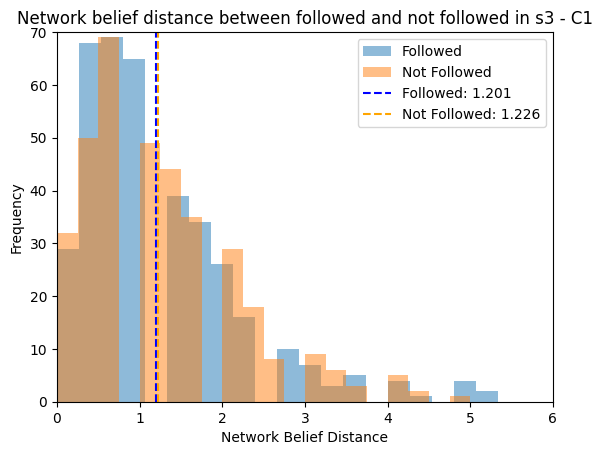

t_statistic -0.34712743815413405
p_value 0.7285942774438139
mean:mean_third_stage_social_signal_Likert_diff_updated_abs 1.5462046204620463
mean:mean_third_stage_not_followed_Likert_diff_updated_abs 2.0984206151288447


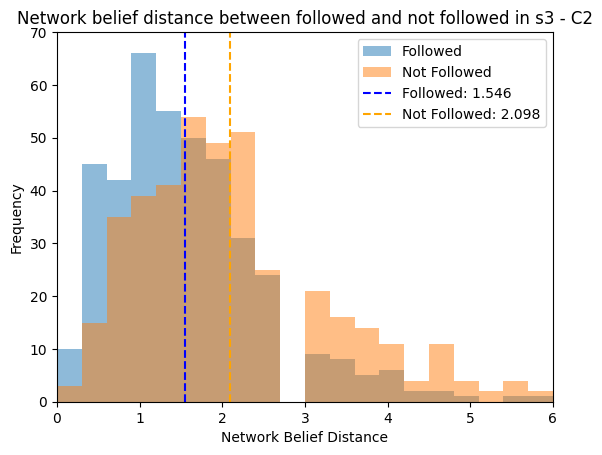

t_statistic -7.167472992990506
p_value 1.7327156268724691e-12
Independent t-test to see if there is difference between followed in case and control. t-statistic: -4.877
P-value: 1.3048222268414763e-06



In [ ]:
#absolute updated
mean_followed_control, mean_not_followed_control = plot_histogram_with_means(combined_df_control,
                                                                             "mean_third_stage_social_signal_Likert_diff_updated_abs", "mean_third_stage_not_followed_Likert_diff_updated_abs",
                                                                             'Network belief distance between followed and not followed in s3 - C1', 'Followed', 'Not Followed')

mean_followed_case, mean_not_followed_case = plot_histogram_with_means(combined_df_case,
                                                                       "mean_third_stage_social_signal_Likert_diff_updated_abs", "mean_third_stage_not_followed_Likert_diff_updated_abs",
                                                                       'Network belief distance between followed and not followed in s3 - C2', 'Followed', 'Not Followed')

#checking difference between followed in case and control
t_statistic, p_value = ttest_ind(combined_df_control['mean_third_stage_social_signal_Likert_diff_updated_abs'].dropna(), combined_df_case['mean_third_stage_social_signal_Likert_diff_updated_abs'].dropna(), equal_var=False)

print(f"Independent t-test to see if there is difference between followed in case and control. t-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value}")
print("")

mean:mean_third_stage_social_signal_Likert_diff_updated_abs 1.2006980802792322
mean:mean_third_stage_total_signal_Likert_diff_updated_abs 1.2060778727445396


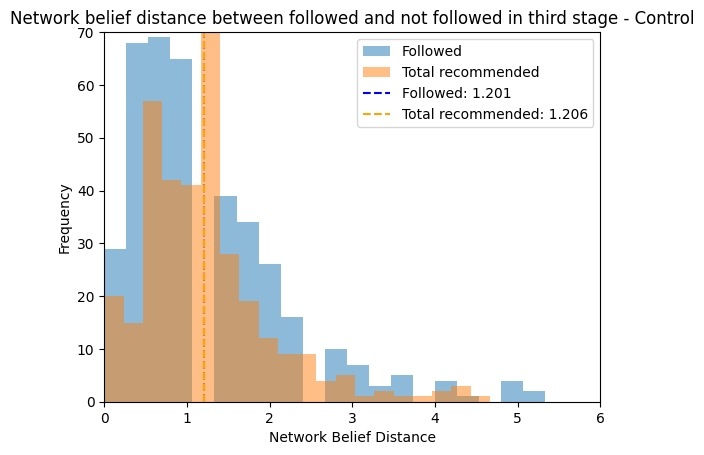

t_statistic -0.08097124459039699
p_value 0.935486984123732
mean:mean_third_stage_social_signal_Likert_diff_updated_abs 1.5462046204620463
mean:mean_third_stage_total_signal_Likert_diff_updated_abs 1.821127946127946


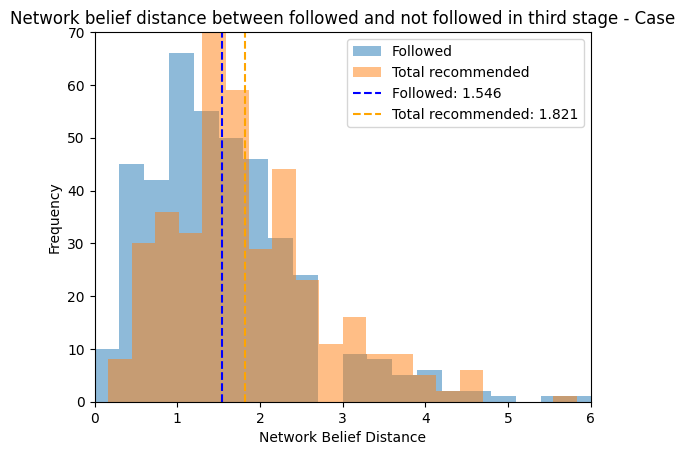

t_statistic -4.0727783202719925
p_value 5.109045288998002e-05


In [ ]:
#absolute updated with total signal
mean_followed_control, mean_total_signal_control = plot_histogram_with_means(combined_df_control,
                                                                             "mean_third_stage_social_signal_Likert_diff_updated_abs", "mean_third_stage_total_signal_Likert_diff_updated_abs",
                                                                             'Network belief distance between followed and not followed in third stage - Control', 'Followed', 'Total recommended')

mean_followed_case, mean_total_signal_case = plot_histogram_with_means(combined_df_case,
                                                                       "mean_third_stage_social_signal_Likert_diff_updated_abs", "mean_third_stage_total_signal_Likert_diff_updated_abs",
                                                                       'Network belief distance between followed and not followed in third stage - Case', 'Followed', 'Total recommended')


mean:mean_third_stage_social_signal_Likert_diff_initial 0.10614035087719297
mean:mean_third_stage_not_followed_Likert_diff_initial 0.05144320297951582


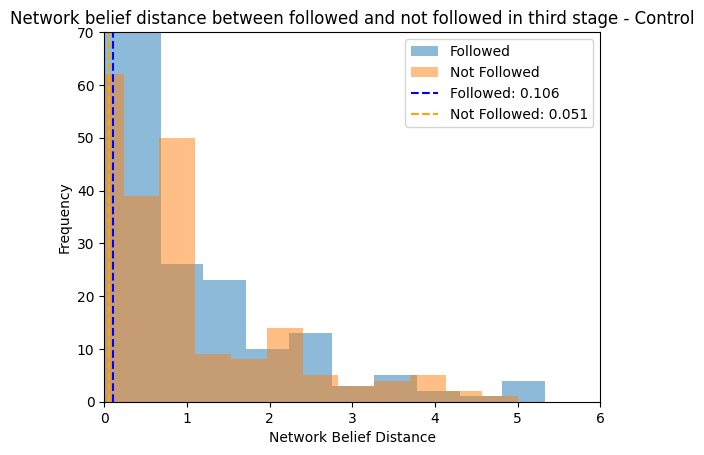

t_statistic 0.5408699917307492
p_value 0.588760847286944
mean:mean_third_stage_social_signal_Likert_diff_initial 0.10614035087719297
mean:mean_third_stage_total_signal_Likert_diff_initial 0.06752626552053484


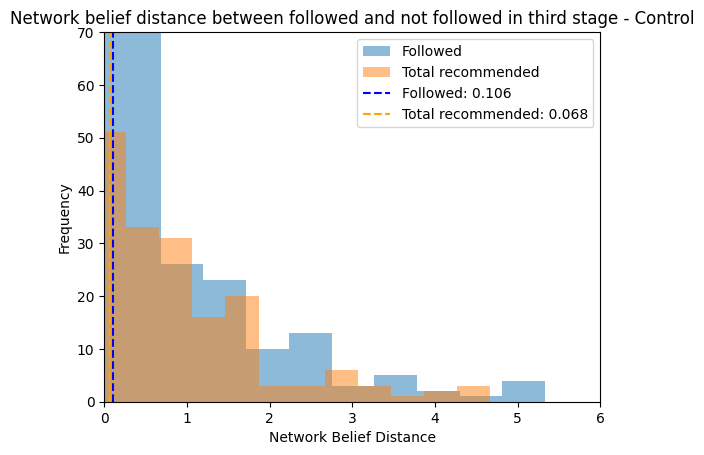

t_statistic 0.39731330311397633
p_value 0.6912530579048763
mean:mean_third_stage_social_signal_Likert_diff_initial 0.22388059701492538
mean:mean_third_stage_not_followed_Likert_diff_initial -0.08533333333333334


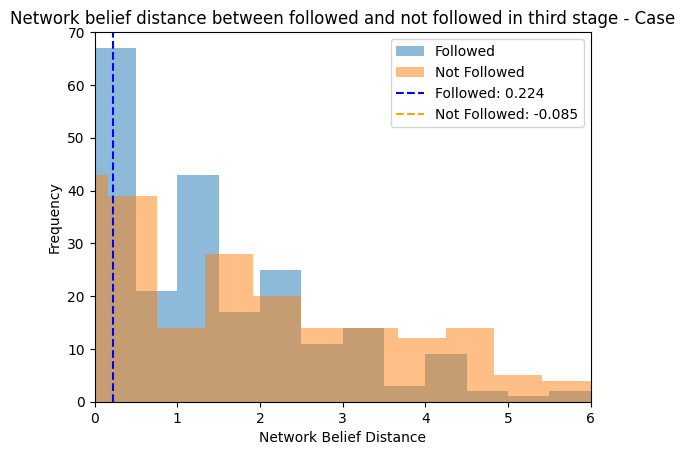

t_statistic 2.146605599569595
p_value 0.03212476541230576
mean:mean_third_stage_social_signal_Likert_diff_initial 0.22388059701492538
mean:mean_third_stage_total_signal_Likert_diff_initial 0.07257383966244729


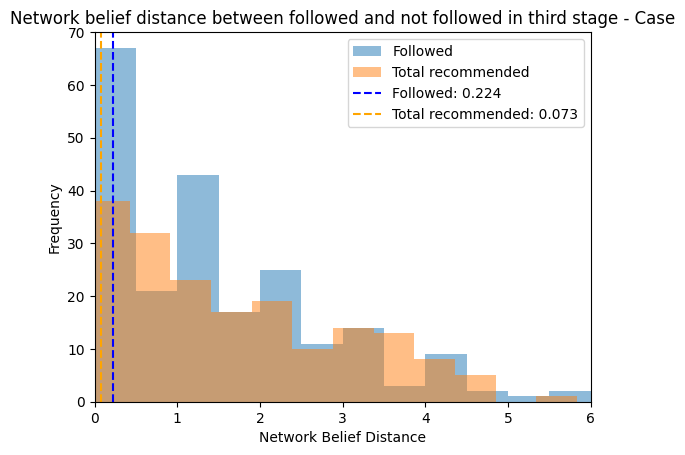

t_statistic 1.2087695491022705
p_value 0.22711078168457208
Independent t-test. t-statistic: -1.060
P-value: 0.28966957001053895



In [ ]:
# Initial non absolute (including total)

mean_followed_control, mean_not_followed_control = plot_histogram_with_means(combined_df_control,
                                                                             "mean_third_stage_social_signal_Likert_diff_initial", "mean_third_stage_not_followed_Likert_diff_initial",
                                                                             'Network belief distance between followed and not followed in third stage - Control', 'Followed', 'Not Followed')


mean_followed_control, mean_total_signal_control = plot_histogram_with_means(combined_df_control,
                                                                             "mean_third_stage_social_signal_Likert_diff_initial", "mean_third_stage_total_signal_Likert_diff_initial",
                                                                             'Network belief distance between followed and not followed in third stage - Control', 'Followed', 'Total recommended')


##############################
mean_followed_case, mean_not_followed_case = plot_histogram_with_means(combined_df_case,
                                                                       "mean_third_stage_social_signal_Likert_diff_initial", "mean_third_stage_not_followed_Likert_diff_initial",
                                                                       'Network belief distance between followed and not followed in third stage - Case', 'Followed', 'Not Followed')


mean_followed_case, mean_total_signal_case = plot_histogram_with_means(combined_df_case,
                                                                       "mean_third_stage_social_signal_Likert_diff_initial", "mean_third_stage_total_signal_Likert_diff_initial",
                                                                       'Network belief distance between followed and not followed in third stage - Case', 'Followed', 'Total recommended')

#checking difference between followed in case and control
t_statistic, p_value = ttest_ind(combined_df_control['mean_third_stage_social_signal_Likert_diff_initial'].dropna(), combined_df_case['mean_third_stage_social_signal_Likert_diff_initial'].dropna(), equal_var=False)
print(f"Independent t-test. t-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value}")
print("")

In [ ]:

# columns_to_save = combined_df_control[["mean_third_stage_social_signal_Likert_diff_initial_abs", "mean_third_stage_total_signal_Likert_diff_initial_abs", "mean_third_stage_not_followed_Likert_diff_initial_abs"]]

# columns_to_save.to_csv('diff_abs_control.csv', index=False)




